# AutoEncoder, VAE

Цели:

* Разобраться с AutoEncoder - реализация на pytorch "from scratch"
* Denoising AutoEncoder - что за зверь
* Variational AE (VAE) - а у меня в запасе ход конём

Содержание:

* [Введение](#intro)
* [Загрузка данных](#load_data)
* AutoEncoder
  * [код AutoEncoder'а](#ae_code)
  * [цикл обучения](#ae_train)
  * [генерация из случайных весов](#ae_generation)
* Denoising AutoEncoder
  * [код](#dae_code)
  * [цикл обучения](#dae_train)
  * [интерполяция изображений](#dae_interp)
* VAE
  * [код](#vae_code)
  * [цикл обучения](#dae_train)
  * [интерполяция изображений](#vae_interp)
  * [визуализация внутренних представлений](#vae_tsne)
* Упражнения

Ссылки:

* [семинар c Alfredo Canziani в рамках NYU Deep Learning, где ЛеКун читает лекции](https://www.youtube.com/watch?v=bZF4N8HR1cc&list=PLLHTzKZzVU9e6xUfG10TkTWApKSZCzuBI)
* ноутбуки семинара - [раз](https://github.com/Atcold/NYU-DLSP21/blob/master/10-autoencoder.ipynb) и [два](https://github.com/Atcold/NYU-DLSP21/blob/master/11-VAE.ipynb)
* [ноутбук с незавершённого курса The Generative Landscape](https://johnowhitaker.github.io/tglcourse/generative_1.html)
* [короткое объяснение AE и VAE на YouTube](https://www.youtube.com/watch?v=9zKuYvjFFS8)


<a name="intro"></a>
## Введение

![autoencoder](https://johnowhitaker.github.io/tglcourse/06_generative_1_files/figure-html/cell-2-output-1.png)

**AutoEncoder** - архитектура нейросети, когда внутри формируется "представление" (representation) в виде вектора и из этого вектора сеть учится восстанавливать исходную информацию.

Состоит из двух частей - энкодера и декодера, энкодер как раз отвечает за преобразование изображения в вектор, а декодер за восстановление исходного изображения из вектора.

Картинка с "The Generative Landscape" курса по ссылке выше. Здесь пример со свёрточными блоками (а не как ниже с линейными слоями), просто для наглядного примера архитектуры автоэнкодера.

Такая постановка задачи заставляет сеть учить внутренние структурные взаимосвязи данных.

In [ ]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from matplotlib import pyplot as plt
from time import time

In [ ]:
def set_default(figsize=(10, 10), dpi=100):
    plt.style.use(['dark_background', 'bmh'])
    plt.rc('axes', facecolor='k')
    plt.rc('figure', facecolor='k')
    plt.rc('figure', figsize=figsize, dpi=dpi)

def to_img(y):
    """Convert vector to image"""
    y = 0.5 * (y + 1)
    y = y.view(y.size(0), 28, 28)
    return y


def display_images(in_, out, n=1):
    """Displaying routine"""
    for N in range(n):
        if in_ is not None:
            in_pic = to_img(in_.cpu().data)
            plt.figure(figsize=(12, 4))
            for i in range(4):
                plt.subplot(1,4,i+1)
                plt.imshow(in_pic[i+4*N])
                plt.axis('off')
        out_pic = to_img(out.cpu().data)
        plt.figure(figsize=(12, 4))
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N])
            plt.axis('off')

In [ ]:
set_default(figsize=(12, 3))

In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

<a name="load_data"></a>
## Загрузка данных

Вспомогательные классы pytorch:

* Dataset - знает пути к данным и как их загрузить
* Dataloader - помогает сформировать батчи для подачи в модель, перемешивает данные при каждом проходе

По умолчанию значения находятся в диапазоне [0, 1], а мы преобразовываем их в диапазон [-1, 1], чтобы сети было легче учиться.

In [ ]:
batch_size = 256

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # to scale images from [0, 1] to [-1, -1]
])

dataset = MNIST('./data', transform=img_transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

## AutoEncoder

<a name="ae_code"></a>

Определим архитектуру модели, функцию потерь (reconstruction loss) и оптимизатор

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


Комментируя строчки с d, мы можем переключаться между стандартным и denoising AE. Главное не забыть передать обновлённые параметры после изменения размерности скрытого слоя в оптимизатор.

In [ ]:
# n = 28 x 28 = 784
d = 30  # for standard AE (under-complete hidden layer)
# d = 500  # for denoising AE (over-complete hidden layer)

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, d),
            nn.Tanh(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(d, 28 * 28),
            nn.Tanh(),
        )

    def forward(self, y):
        h = self.encoder(y)
        y_tilda = self.decoder(h)
        return y_tilda

ae = Autoencoder().to(device)
criterion = nn.MSELoss()

In [ ]:
learning_rate = 1e-3

optimizer = torch.optim.Adam(
    ae.parameters(),
    lr=learning_rate,
)

<a name="ae_train"></a>
### Цикл обучения AE

* изображение прогоняем через нашу модель
* считаем значение функции потерь
* вычисляем частные производные функции потерь относительно параметров модели (градиент)
* делаем шаг в обратном направлении

В конце каждой эпохи визуализируем вывод модели и можем наблюдать, как она обучается по эпохам.

**TODO:** для чего zero_grad

epoch [1/20], loss:0.2059, elapsed: 19.2s
epoch [2/20], loss:0.1469, elapsed: 12.5s
epoch [3/20], loss:0.1233, elapsed: 12.4s
epoch [4/20], loss:0.1008, elapsed: 16.0s
epoch [5/20], loss:0.0985, elapsed: 13.1s
epoch [6/20], loss:0.0904, elapsed: 14.5s
epoch [7/20], loss:0.0877, elapsed: 14.6s
epoch [8/20], loss:0.0748, elapsed: 13.8s
epoch [9/20], loss:0.0792, elapsed: 17.7s
epoch [10/20], loss:0.0709, elapsed: 15.0s
epoch [11/20], loss:0.0771, elapsed: 13.1s
epoch [12/20], loss:0.0734, elapsed: 15.2s
epoch [13/20], loss:0.0634, elapsed: 14.9s
epoch [14/20], loss:0.0682, elapsed: 12.4s
epoch [15/20], loss:0.0686, elapsed: 12.3s
epoch [16/20], loss:0.0642, elapsed: 12.4s
epoch [17/20], loss:0.0631, elapsed: 12.3s
epoch [18/20], loss:0.0592, elapsed: 12.2s
epoch [19/20], loss:0.0594, elapsed: 12.2s
epoch [20/20], loss:0.0541, elapsed: 12.8s


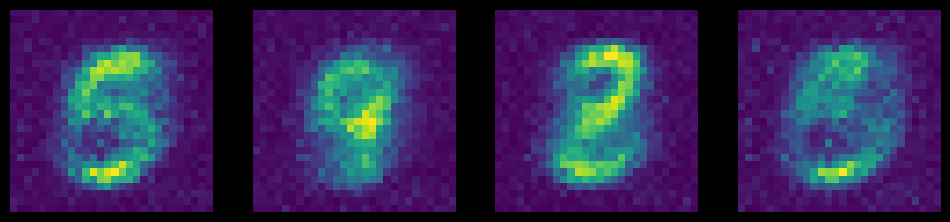

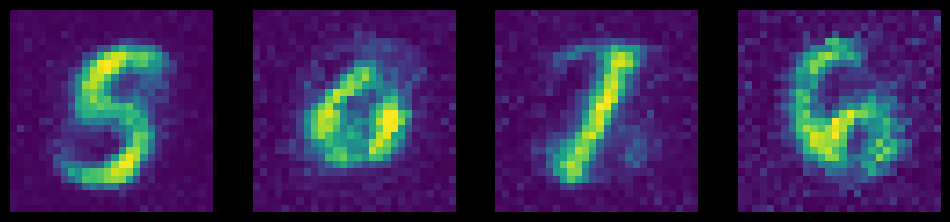

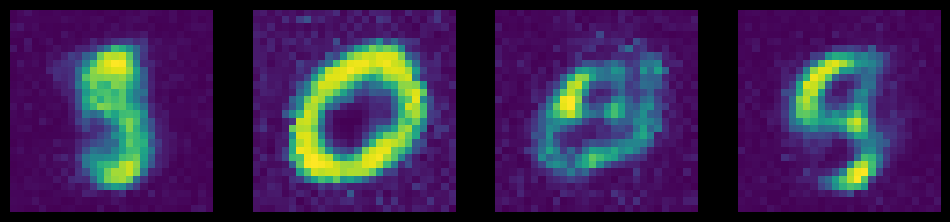

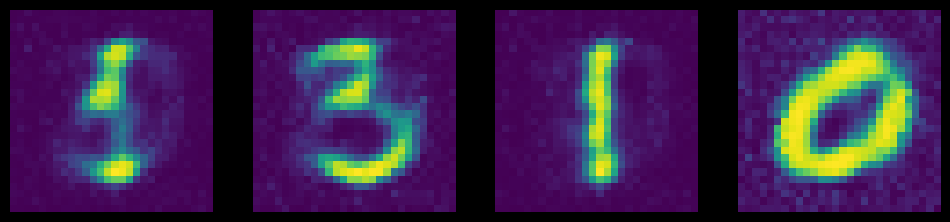

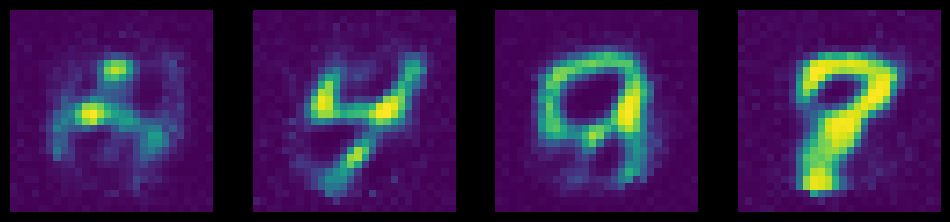

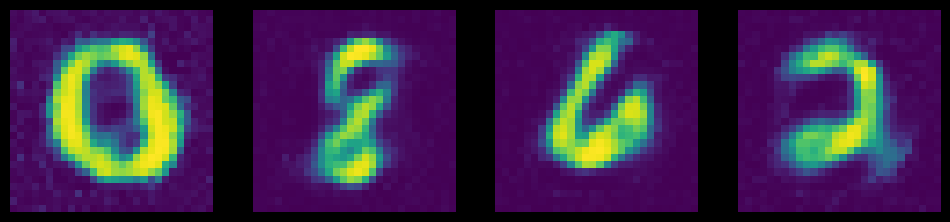

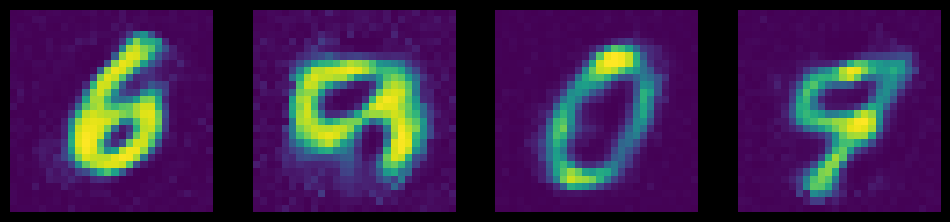

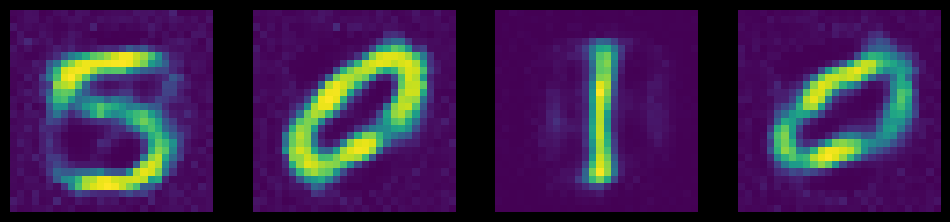

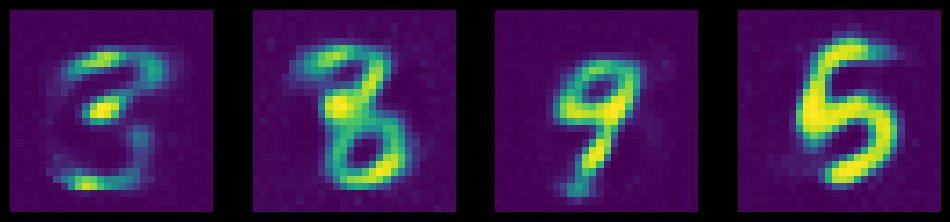

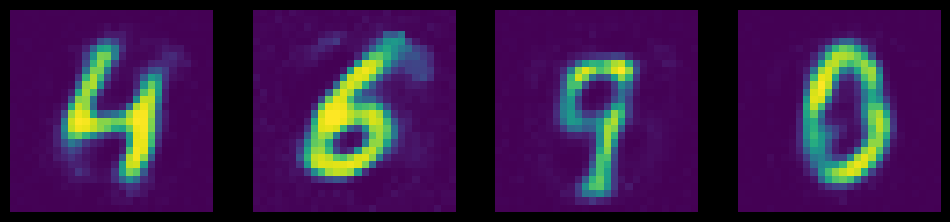

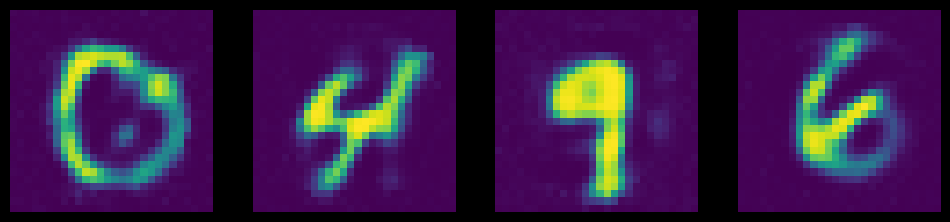

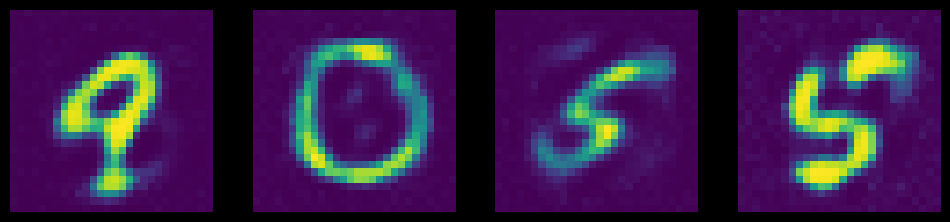

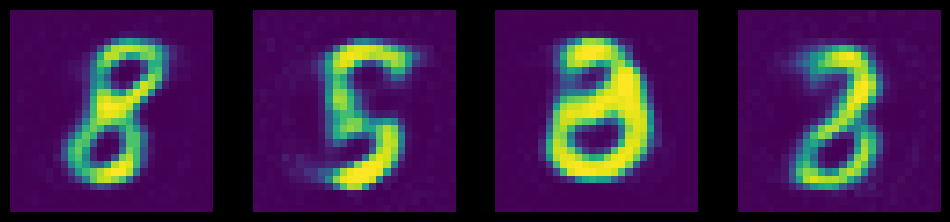

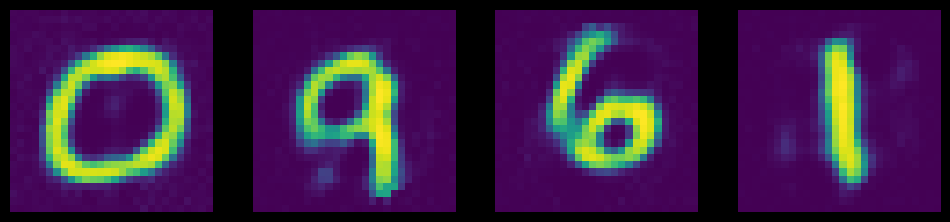

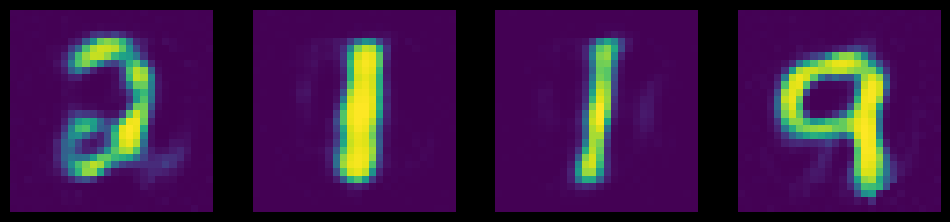

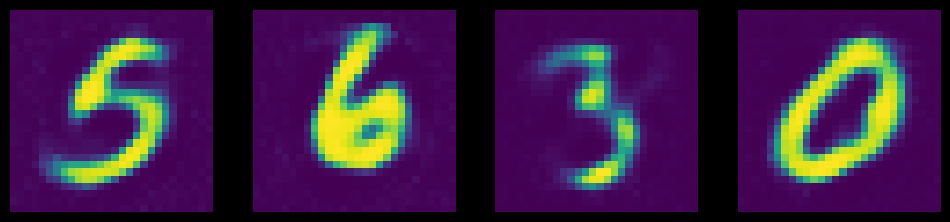

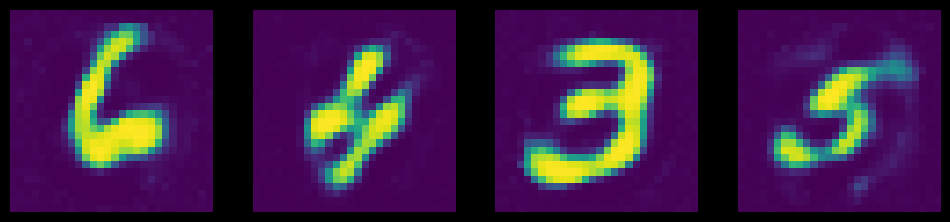

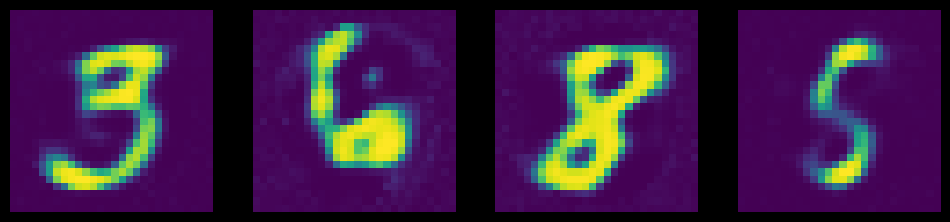

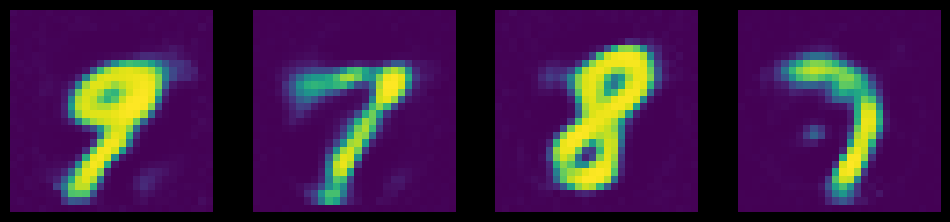

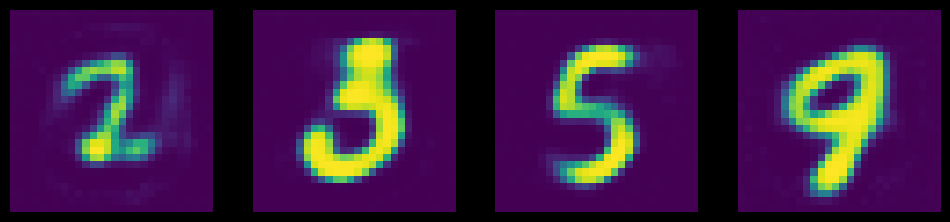

In [ ]:
num_epochs = 20
# do = nn.Dropout()  # comment out for standard AE
for epoch in range(num_epochs):
    t0 = time()
    for data in dataloader:
        img, _ = data  # we don't need class labels
        img = img.to(device)
        img = img.view(img.size(0), -1)
        # noise = do(torch.ones(img.shape)).to(device)
        # img_bad = (img * noise).to(device)  # comment out for standard AE
        # ===================forward=====================
        output = ae(img)  # feed <img> (for std AE) or <img_bad> (for denoising AE)
        loss = criterion(output, img.data)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print(f'epoch [{epoch + 1}/{num_epochs}], loss:{loss.item():.4f}, elapsed: {time() - t0:.1f}s')
    display_images(None, output)  # pass (None, output) for std AE, (img_bad, output) for denoising AE

<a name="viz_ae_weights"></a>
### Визуализация "ядер" (весов энкодера)

Посмотрим на первые 8 ядер (всего их d).

Мы видим характерные паттерны в центре (фиолетовый цвет -1, жёлтый цвет 1), где обычно располагаются цифры. Вокруг этого случайный шум, который в среднем даёт 0 для фоновых областей изображений. То есть модель поняла, что по краям изображений нет полезной информации.

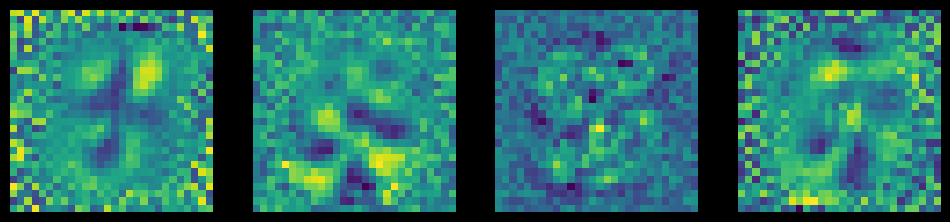

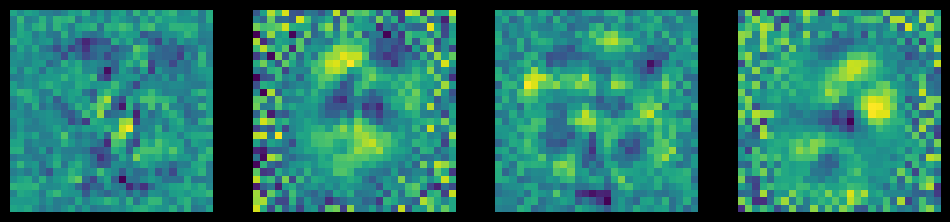

In [ ]:
display_images(None, ae.encoder[0].weight, 2)

<a name="ae_train"></a>

### Генерация из случайных векторов

Попробуем сгенерировать изображения из случайным образом сэмплированных векторов.

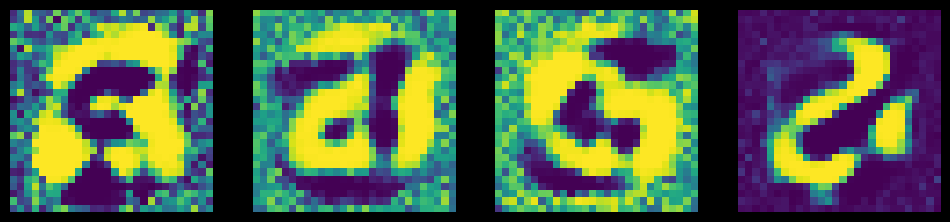

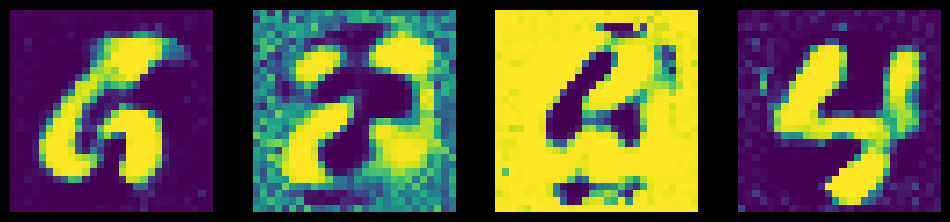

In [ ]:
display_images(None, ae.decoder(torch.randn(8, d).to(device)), 2)

Получается ерунда, но мы и не старались выучить красивое представление данных. Модель выучила лишь то, чему её учили и для примеров из обучающей выборки есть компактное отображение в какие-то области латентное пространство, в то время, как остальная часть пространства не используется.

Это свойство автоэнкодера раньше часто использовалось для обнаружения аномалий и поиска выбросов в сложных пространствах, как например телеметрия с большого количества датчиков. Прогоняем образец через модель и если полученный вектор представления далеко отстоит от представлений обучающей выборки в латентном пространстве - это не типичный образец, который можно подвергать дальнейшему анализу.

Для того, чтобы получить хорошее представление, нужно добавить компоненты в лосс, которые будут способствовать отображению в компактную область подпространства, вернёмся к этому позже.

## Denoising AutoEncoder

Изменим размерность латентного пространства c 30 на 500.

In [ ]:
# Define model architecture and reconstruction loss

# n = 28 x 28 = 784
# d = 30  # for standard AE (under-complete hidden layer)
d = 500  # for denoising AE (over-complete hidden layer)

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, d),
            nn.Tanh(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(d, 28 * 28),
            nn.Tanh(),
        )

    def forward(self, y):
        h = self.encoder(y)
        y_tilda = self.decoder(h)
        return y_tilda

dae = Autoencoder().to(device)
criterion = nn.MSELoss()

In [ ]:
learning_rate = 1e-3

optimizer = torch.optim.Adam(
    dae.parameters(),
    lr=learning_rate,
)

<a name="dae_train"></a>

### Цикл обучения Denoising AE

* добавим вектор шума, который занулит 50% пикселей входного изображения
* на вход будем подавать зашумлённое изображение, на выходе получать исходное

epoch [1/20], loss:0.0686, elapsed: 15.8s
epoch [2/20], loss:0.0538, elapsed: 15.8s
epoch [3/20], loss:0.0535, elapsed: 16.0s
epoch [4/20], loss:0.0509, elapsed: 15.7s
epoch [5/20], loss:0.0486, elapsed: 15.5s
epoch [6/20], loss:0.0491, elapsed: 16.0s
epoch [7/20], loss:0.0515, elapsed: 15.8s
epoch [8/20], loss:0.0491, elapsed: 16.2s
epoch [9/20], loss:0.0440, elapsed: 15.8s
epoch [10/20], loss:0.0433, elapsed: 15.4s
epoch [11/20], loss:0.0436, elapsed: 15.6s


<ipython-input-2-ddd6e2ae2c68>:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(12, 4))


epoch [12/20], loss:0.0387, elapsed: 15.6s
epoch [13/20], loss:0.0414, elapsed: 15.7s
epoch [14/20], loss:0.0419, elapsed: 15.9s
epoch [15/20], loss:0.0430, elapsed: 15.5s
epoch [16/20], loss:0.0412, elapsed: 15.7s
epoch [17/20], loss:0.0405, elapsed: 15.9s
epoch [18/20], loss:0.0392, elapsed: 15.6s
epoch [19/20], loss:0.0400, elapsed: 15.7s
epoch [20/20], loss:0.0388, elapsed: 16.0s


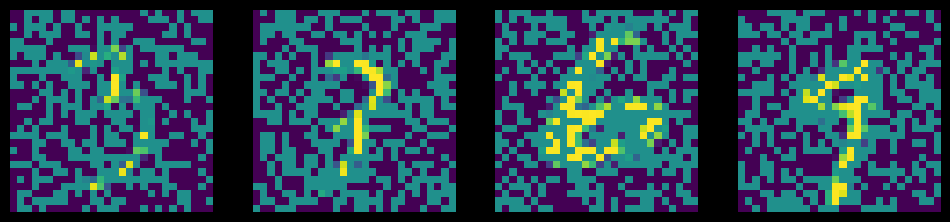

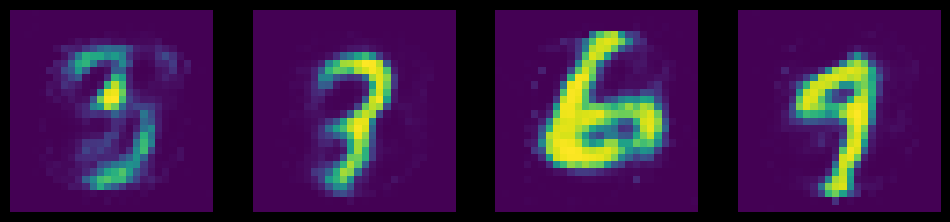

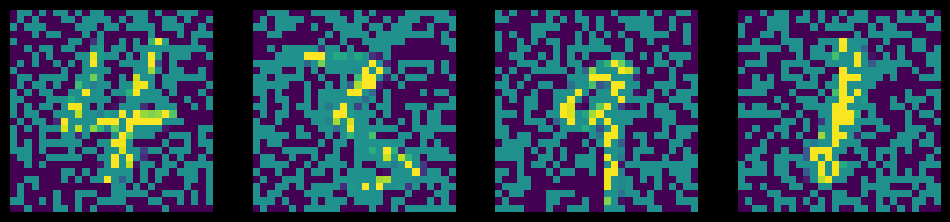

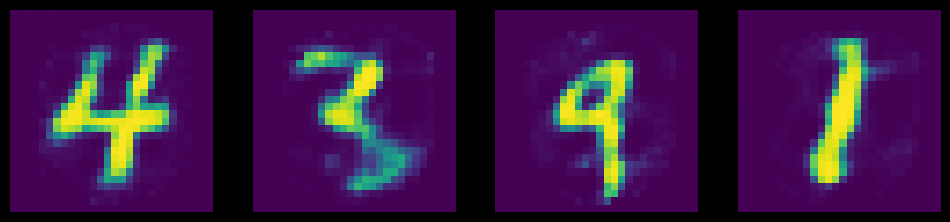

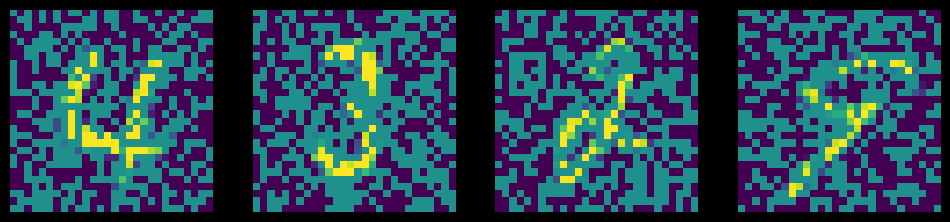

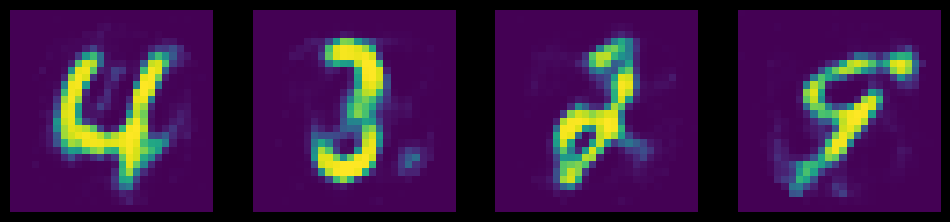

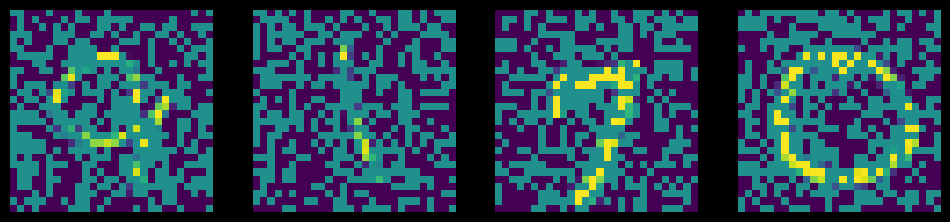

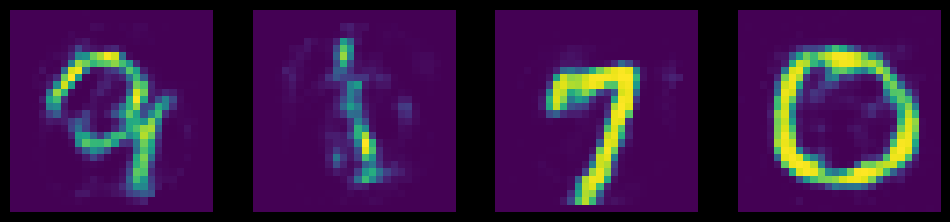

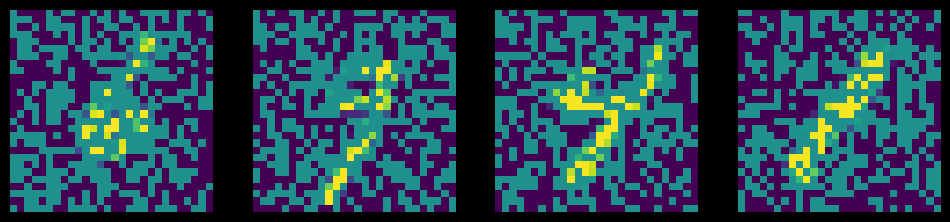

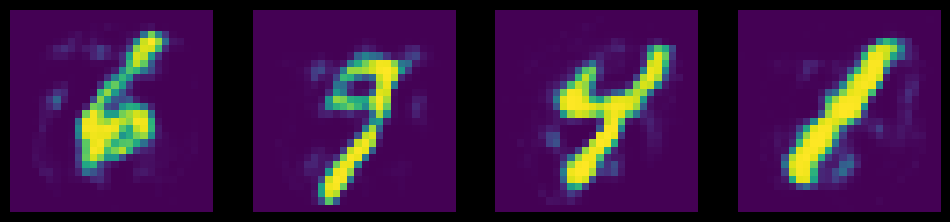

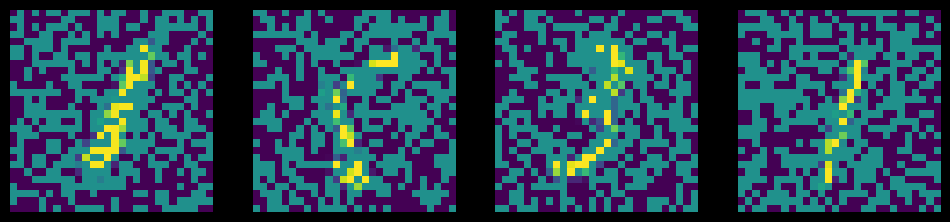

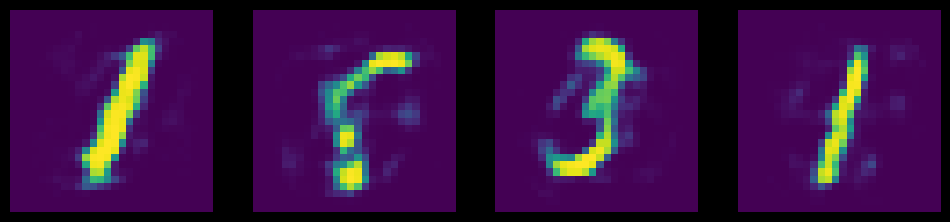

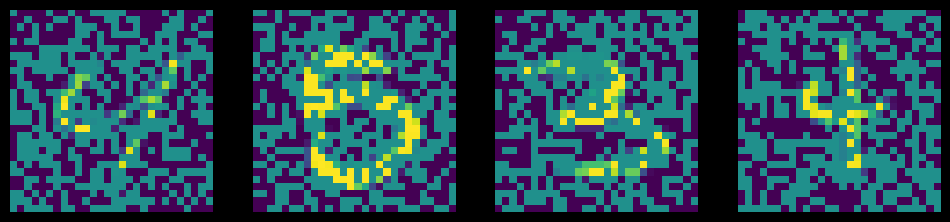

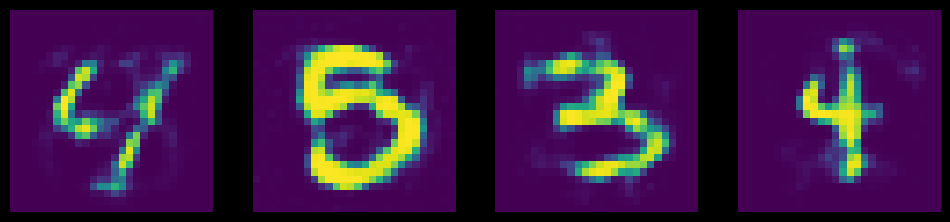

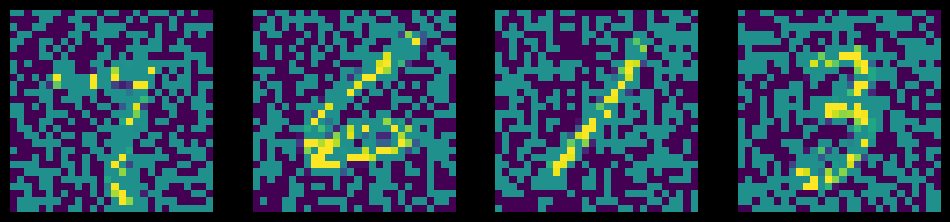

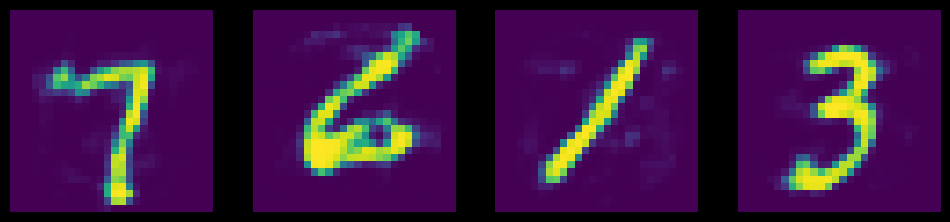

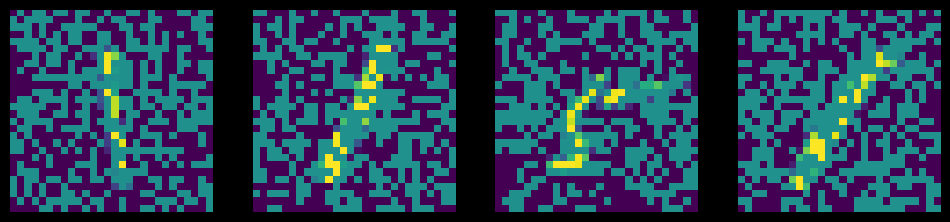

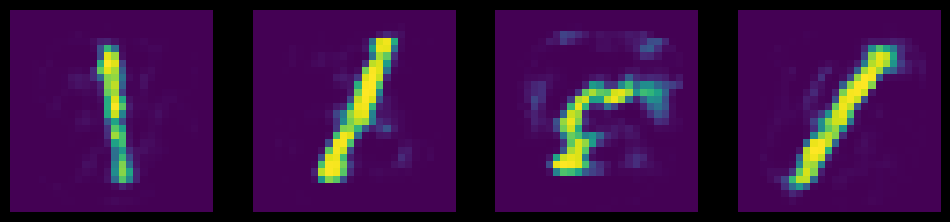

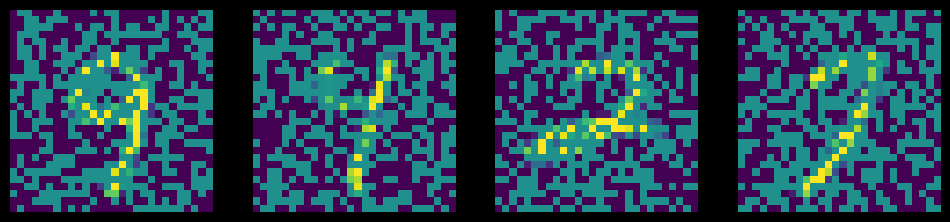

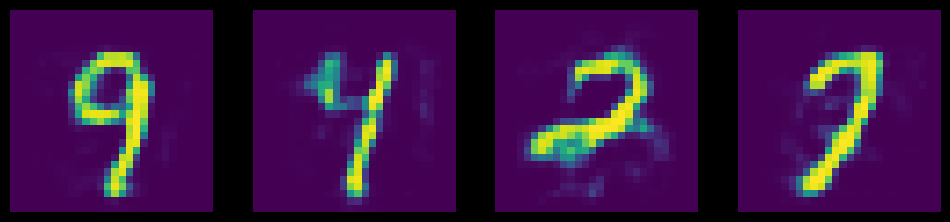

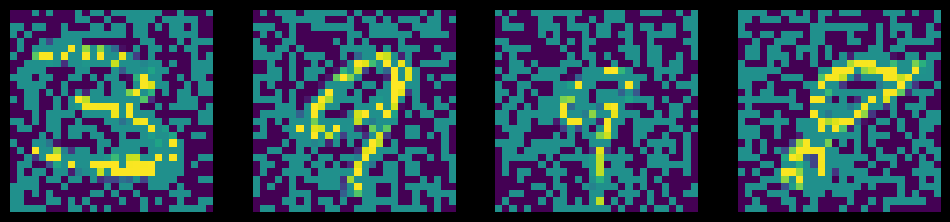

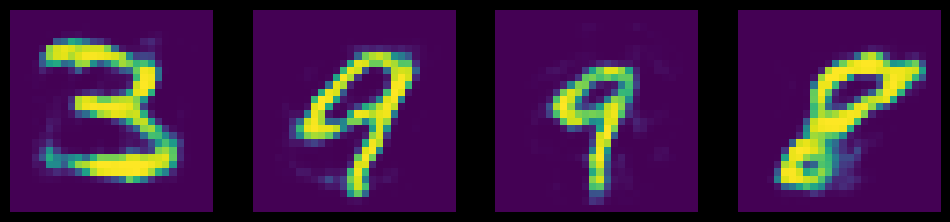

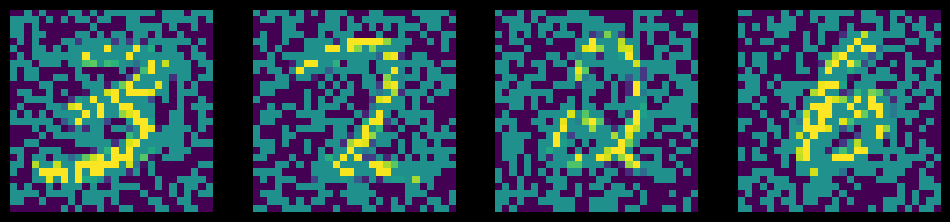

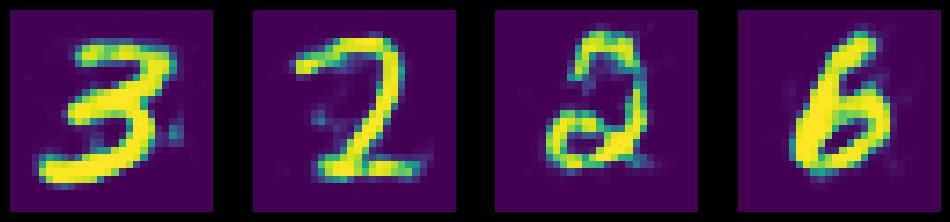

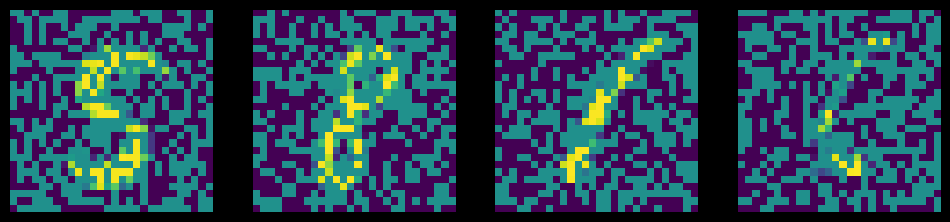

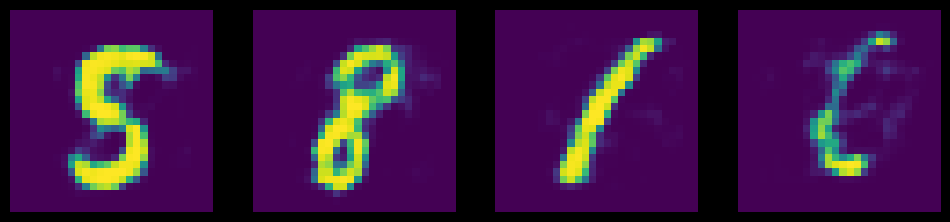

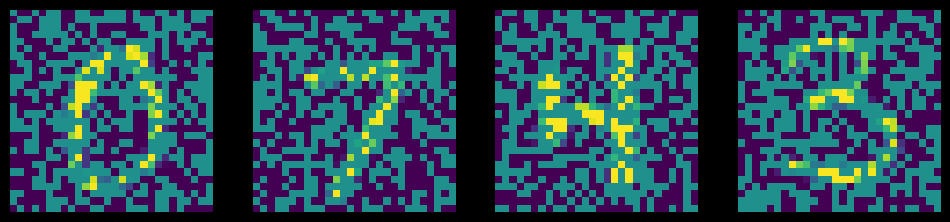

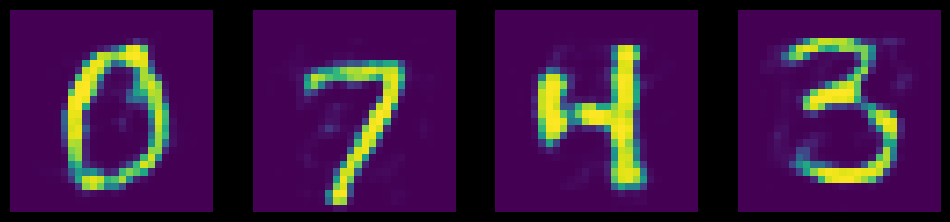

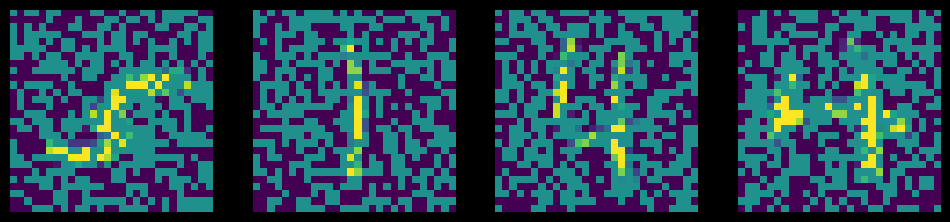

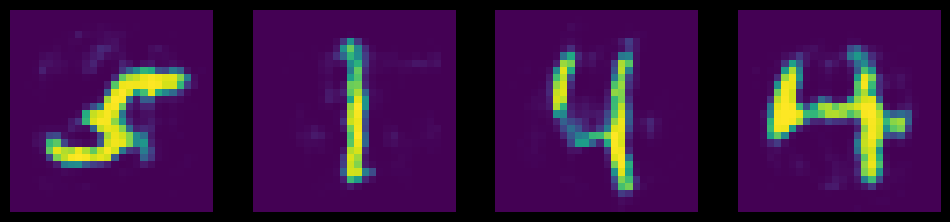

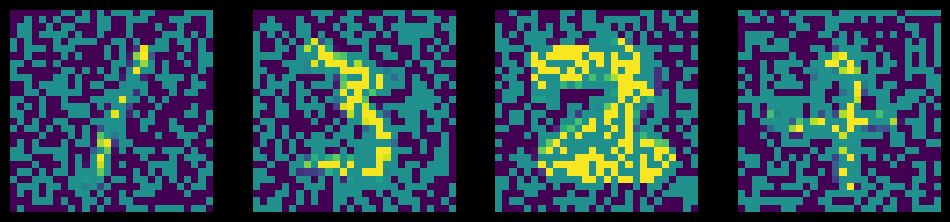

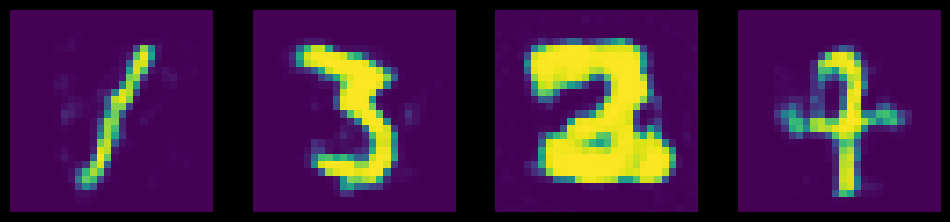

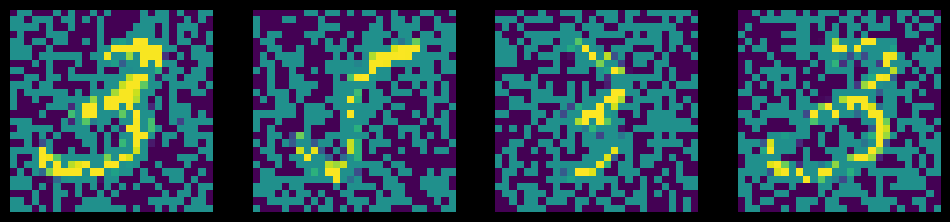

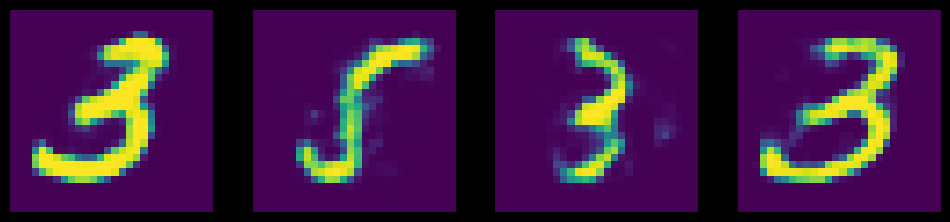

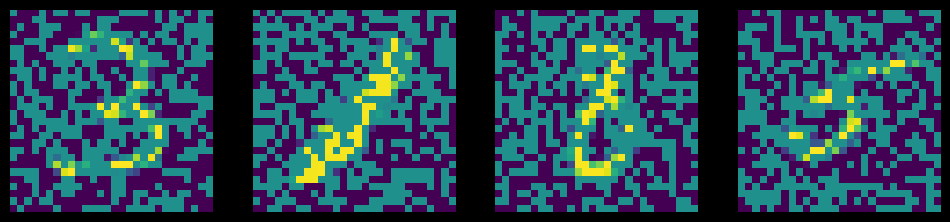

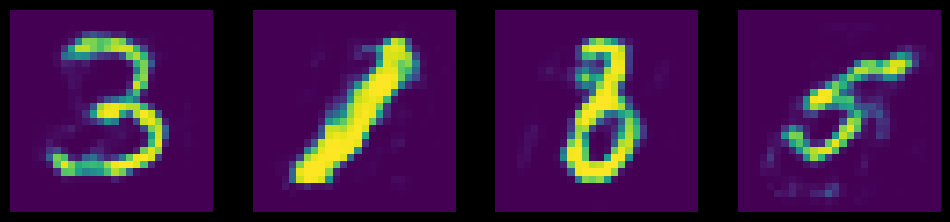

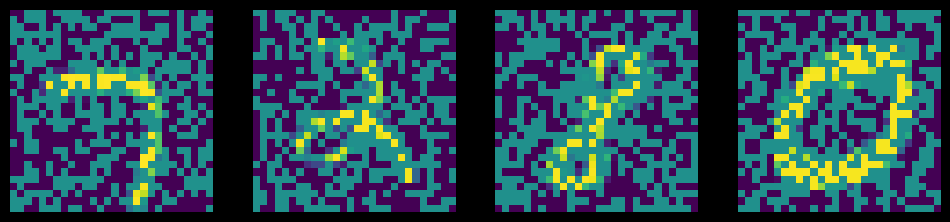

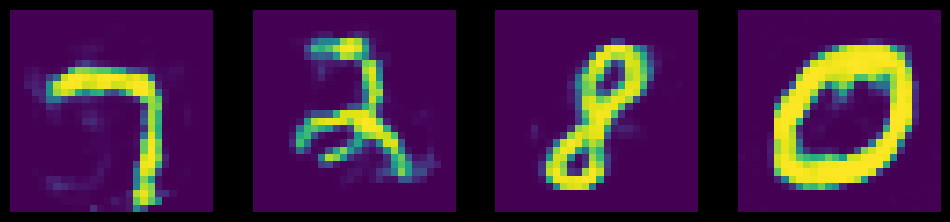

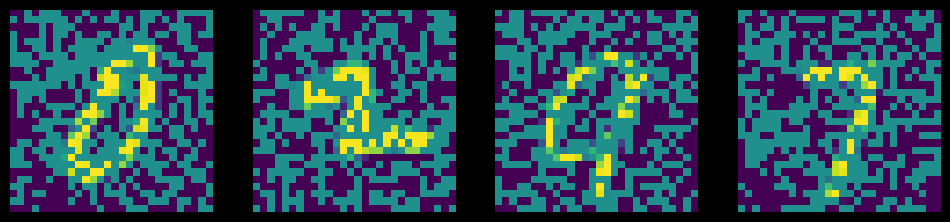

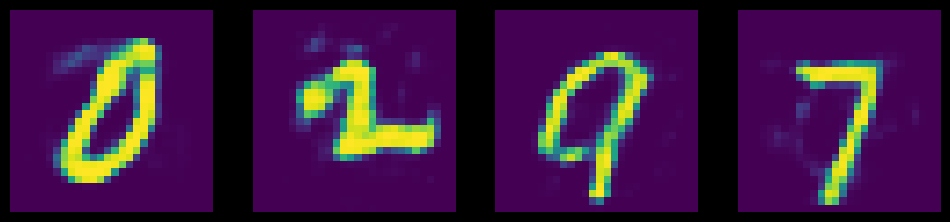

In [ ]:
num_epochs = 20
do = nn.Dropout()  # comment out for standard AE
for epoch in range(num_epochs):
    t0 = time()
    for data in dataloader:
        img, _ = data
        img = img.to(device)
        img = img.view(img.size(0), -1)
        noise = do(torch.ones(img.shape)).to(device)
        img_bad = (img * noise).to(device)  # comment out for standard AE
        # ===================forward=====================
        output = dae(img_bad)  # feed <img> (for std AE) or <img_bad> (for denoising AE)
        loss = criterion(output, img.data)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print(f'epoch [{epoch + 1}/{num_epochs}], loss:{loss.item():.4f}, elapsed: {time() - t0:.1f}s')
    display_images(img_bad, output)  # pass (None, output) for std AE, (img_bad, output) for denoising AE

### Визуализация "ядер" (весов энкодера)

Характерные паттерны в центре остались, а вокруг вместо случайного шума нули. То есть модель поняла, что по краям зашумлённых изображений находится только шум, который надо устранить.

Исключение составляют ядра, которые состоят целиком из шума. Эти ребята ничего не выучили и таких здесь больше, чем в обычном AE, так как и размерность латентного пространства больше. Можно попробовать уменьшить размерность.

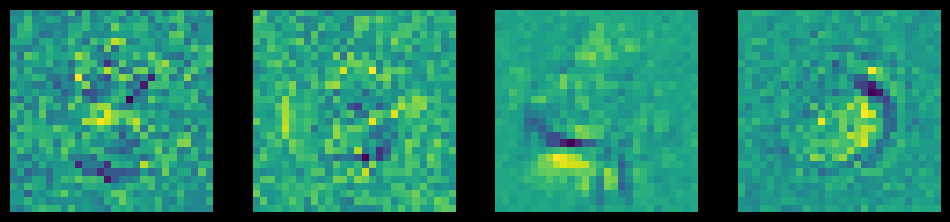

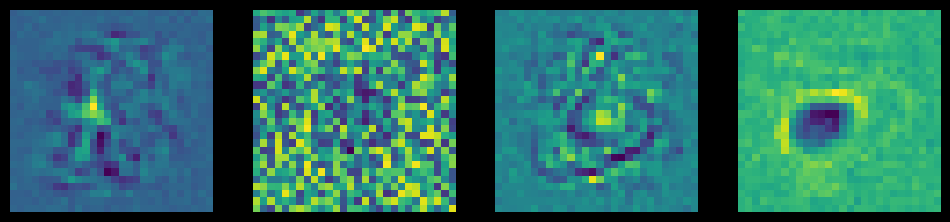

In [ ]:
display_images(None, dae.encoder[0].weight, 2)

<a name="ae_interp"></a>
### Интерполяция изображений

Попробуем посчитать арифметическое среднее двух изображений и подать его в модель. Видим, что на входе что-то среднее, а на выходе модель постаралась восстановить какую-то цифру, но вышло так себе. Это как раз свойство представлений автоэнкодера, которые мы обсуждали выше, что оно не определено только для некоторых областей пространства.

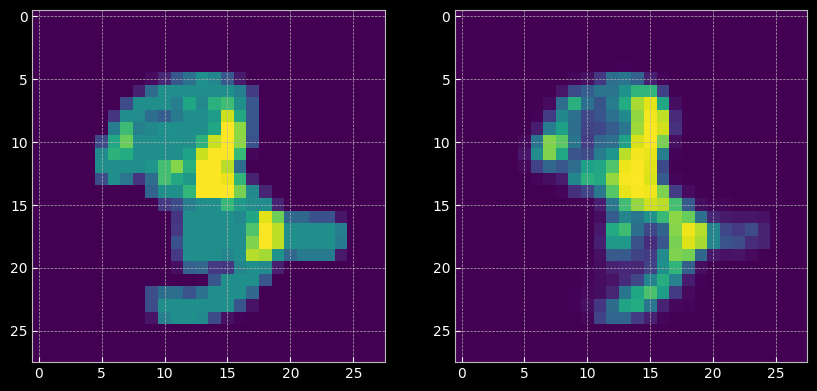

In [ ]:
y = (img[1:2] + img[15:16])/2
with torch.no_grad():
    y_tilda = dae(y)
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(to_img(y.cpu()).squeeze())
plt.subplot(122)
plt.imshow(to_img(y_tilda.cpu()).squeeze());

## VAE

Данные загрузим заново и не будем переводить в диапазон [-1, 1].

У нас появится случайное сэмплирование, зафиксируем random seed.

In [ ]:
# TODO: Сделать единую функцию display_images

def display_images(in_, out, n=1, label='', count=False, energy=None):
    for N in range(n):
        if in_ is not None:
            in_pic = in_.data.cpu().view(-1, 28, 28)
            plt.figure(figsize=(12, 4))
            plt.suptitle(label + ' – real test data / reconstructions', color='w', fontsize=16)
            for i in range(4):
                plt.subplot(1,4,i+1)
                plt.imshow(in_pic[i+4*N])
                plt.axis('off')
        out_pic = out.data.cpu().view(-1, 28, 28)
        plt.figure(figsize=(12, 4))
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N])
            plt.axis('off')
            c = 4 * N + i
            if count: plt.title(str(c), color='w')
            if count and energy is not None: plt.title(f'{c}, e={energy[c].item():.2f}', color='w')

In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [ ]:
# Define data loading step

batch_size = 256

kwargs = {'num_workers': 1, 'pin_memory': True}
train_loader = torch.utils.data.DataLoader(
    MNIST('./data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    MNIST('./data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

**TODO:** Переписать и добавить картинку с одинаковым изображением для AE и VAE

Архитектура VAE почти идентична AE выше, за исключением того, что вместо того, чтобы отображать входные данные в вектор, мы отображаем в распределение. И вектор на выходе энкодера заменяется заменяется двумя векторами, один из которых соответствует среднему, а другой - СКО этого распределения. И тогда для того, чтобы получить изображение нам нужно сэмплировать вектор из этого распределения и пропустить через декодер.

Декодер при этом вообще не изменился.

Здесь есть одна проблема, т.к. у нас появляется в середине сетки появляется операция сэмплирования, через которую нельзя пропустить градиенты. А нам нужно обучать всю сеть от начала до конца.

Чтобы решить эту проблему, применили "reparametrization trick", когда случайный вектор расписывается как $x = \mu + \sigma*\epsilon$, где $\epsilon \in \mathcal{N}(0, 1)$. Тогда мы обучаем μ и σ, в то время как \epsion нам не важен, он просто сэмпл из стандартного нормального распределения.
Т.е. вместо случайного узла в сети, через который не смогут пройти градиенты, мы разбиваем его на части - одна через которую смогут пройти градиенты (μ и σ), а другая по прежнему остаётся случайной, но мы и не хотим её тренировать т.к. она фиксированная для нас.

Вместо обычного среднеквадратичного отклонения (СКО) работаем с логарифмом дисперсии, который потом превращается в СКО `torch.exp(0.5*logvar))`. Это просто изменение масштаба дисперсии (которая положительна), на всю вещественную ось и растягивание небольших значений около нуля.

Для восстановления изображения сэмплируем из нормального распределения для получения латентного представления `z`, которое отправляется в декодер.

In [ ]:
# Defining the model

d = 20

class VAE(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(784, d ** 2),
            nn.ReLU(),
            nn.Linear(d ** 2, d * 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(d, d ** 2),
            nn.ReLU(),
            nn.Linear(d ** 2, 784),
            nn.Sigmoid(),
        )

    def reparameterise(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = std.data.new(std.size()).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

    def forward(self, y):
        mu_logvar = self.encoder(y.view(-1, 784)).view(-1, 2, d)
        mu = mu_logvar[:, 0, :]
        logvar = mu_logvar[:, 1, :]
        z = self.reparameterise(mu, logvar)
        return self.decoder(z), mu, logvar

vae = VAE().to(device)

In [ ]:
learning_rate = 1e-3

optimizer = torch.optim.Adam(
    vae.parameters(),
    lr=learning_rate,
)

**TODO:** Переписать, добавить формулу и пруфы почему KLD минимальна при σ=1 и μ=0

Вместо готовой функции потерь используем функцию, которая будет комбинировать Binary Cross Entropy (BCE) и Kullback-Leibler Divergence (KLD).

BCE используется для минимизации ошибки восстановления данных. Если у вас возник вопрос - почему BCE, то [вы не одиноки](https://stats.stackexchange.com/questions/370179/why-binary-crossentropy-can-be-used-as-the-loss-function-in-autoencoders)

![KLD](https://drive.google.com/uc?export=download&id=1-x4Rr-jWjWhhl70RwDh7khVJzTOF_mMM)

KLD составляющая минимальна, когда дисперсия равна 1, а среднее равно нулевому вектору, то есть это расстояние нормального распределения соответствующего дисперсии и среднему на выходе энкодера от стандартного нормального распределения. Мы хотим, чтобы наше распределение было близко к стандартному нормальному.

Таким образом это способствует тому, чтобы эмбеддинги в латентном пространстве располагались более компактно, в соответствии со стандартным распределением.



In [ ]:
def loss_function(y_tilda, y, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(
        y_tilda, y.view(-1, 784), reduction='sum'
    )
    KLD = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))
    return BCE + KLD

### Цикл обучения VAE

* для первой эпохи пропускаем обучение, чтобы посчитать тестовый лосс на необученной сети
* пропускаем входное изображение через модель
* получаем восстановленное изображение, среднее и логарифм дисперсии
* считаем функцию потерь и делаем шаг в противоположную градиенту сторону

**TODO:** Разделить VAE на составные части (и лосс не должен быть большим 😉)

====> Test set loss: 543.2947
====> Epoch: 1 Average loss: 187.8796, elapsed: 10.4s
====> Test set loss: 134.1229
====> Epoch: 2 Average loss: 131.5680, elapsed: 11.0s
====> Test set loss: 114.9464
====> Epoch: 3 Average loss: 120.7002, elapsed: 10.9s
====> Test set loss: 108.3692
====> Epoch: 4 Average loss: 116.0298, elapsed: 10.4s
====> Test set loss: 104.9453
====> Epoch: 5 Average loss: 113.3332, elapsed: 10.5s
====> Test set loss: 102.9867
====> Epoch: 6 Average loss: 111.5406, elapsed: 10.4s
====> Test set loss: 101.6783
====> Epoch: 7 Average loss: 110.2832, elapsed: 10.4s
====> Test set loss: 100.3237
====> Epoch: 8 Average loss: 109.3261, elapsed: 10.6s
====> Test set loss: 100.3245
====> Epoch: 9 Average loss: 108.5821, elapsed: 10.3s
====> Test set loss: 99.4435
====> Epoch: 10 Average loss: 107.9413, elapsed: 10.2s
====> Test set loss: 98.6867


<ipython-input-18-752c6ce2c504>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(12, 4))


====> Epoch: 11 Average loss: 107.3672, elapsed: 10.1s
====> Test set loss: 98.2471
====> Epoch: 12 Average loss: 106.9612, elapsed: 10.0s
====> Test set loss: 98.7290
====> Epoch: 13 Average loss: 106.5316, elapsed: 10.4s
====> Test set loss: 97.6957
====> Epoch: 14 Average loss: 106.1980, elapsed: 10.2s
====> Test set loss: 96.6749
====> Epoch: 15 Average loss: 105.9203, elapsed: 9.7s
====> Test set loss: 96.2904
====> Epoch: 16 Average loss: 105.6759, elapsed: 9.6s
====> Test set loss: 96.4542
====> Epoch: 17 Average loss: 105.4048, elapsed: 9.8s
====> Test set loss: 96.9113
====> Epoch: 18 Average loss: 105.2128, elapsed: 9.6s
====> Test set loss: 96.5379
====> Epoch: 19 Average loss: 105.0273, elapsed: 9.6s
====> Test set loss: 96.2467
====> Epoch: 20 Average loss: 104.8268, elapsed: 10.2s
====> Test set loss: 95.6796


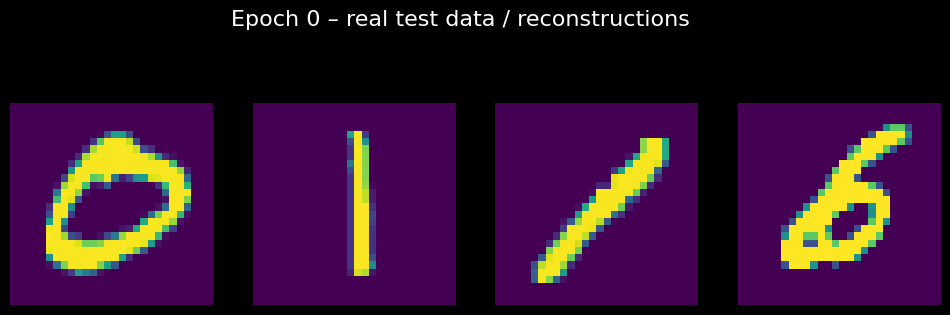

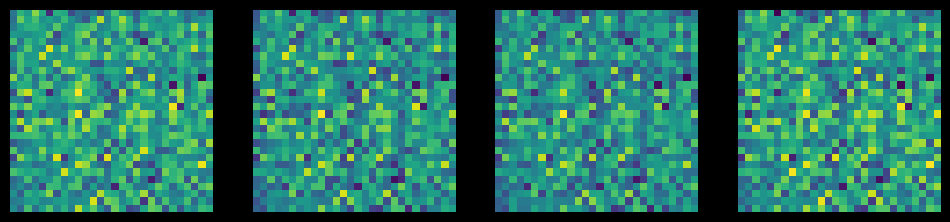

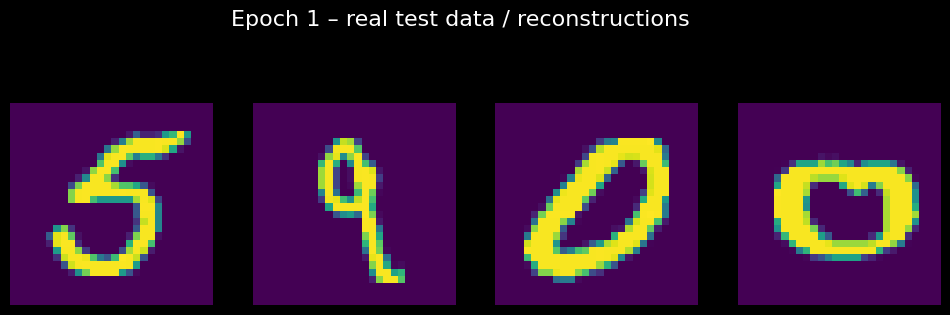

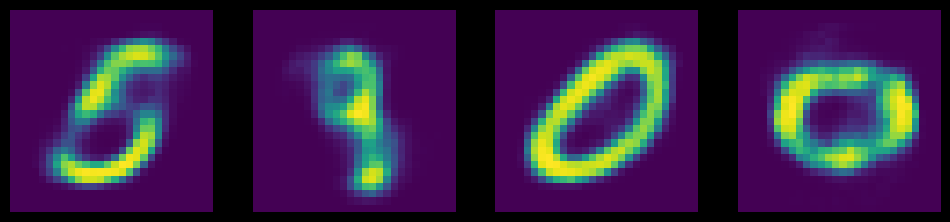

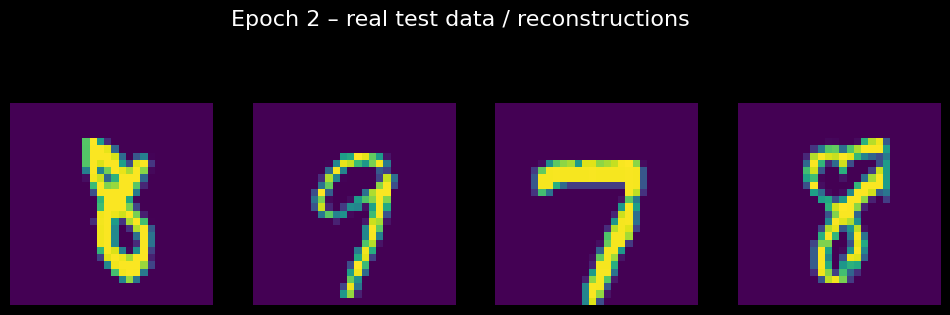

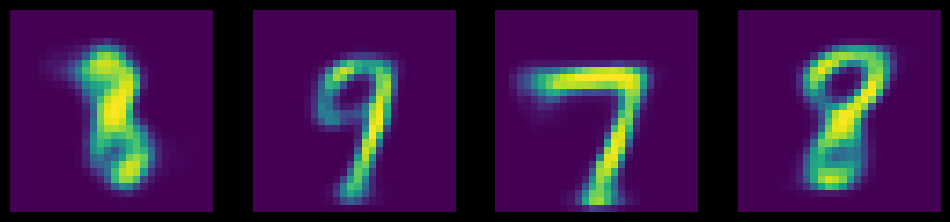

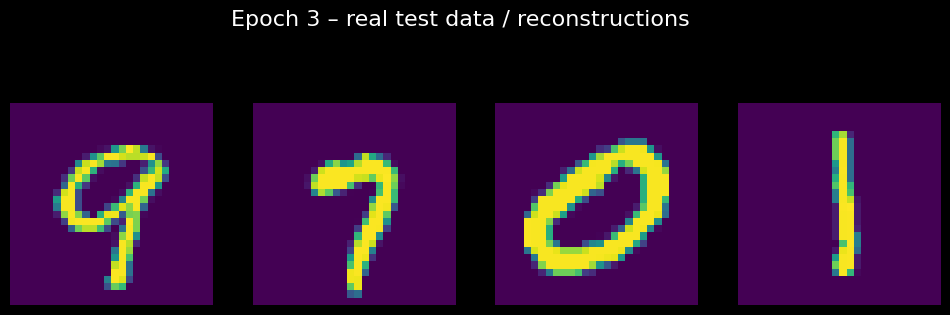

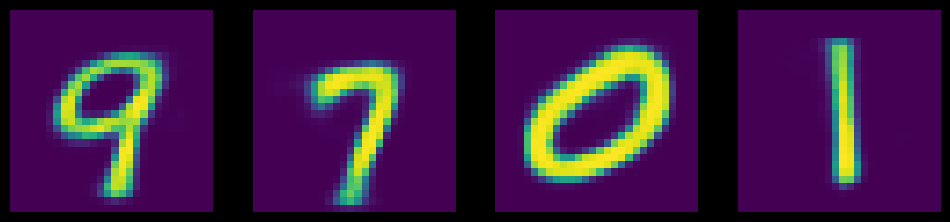

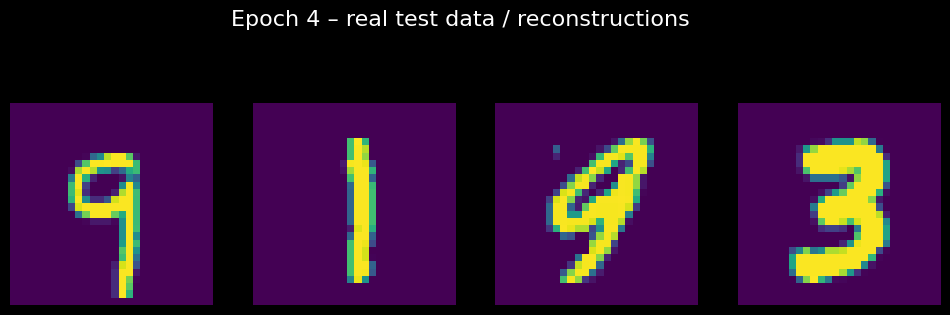

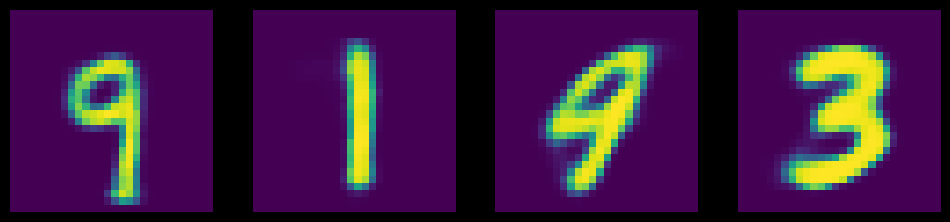

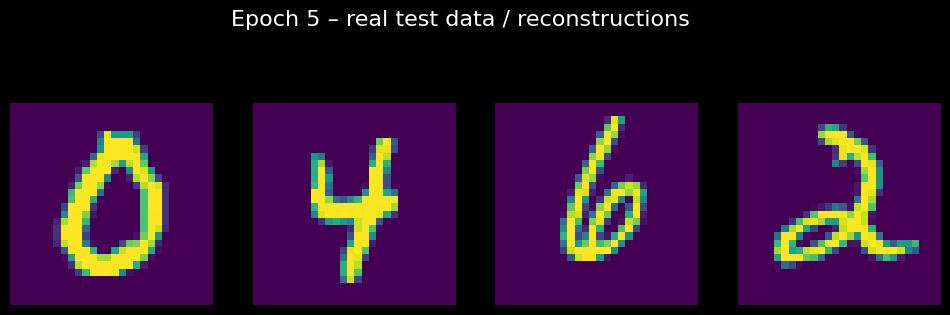

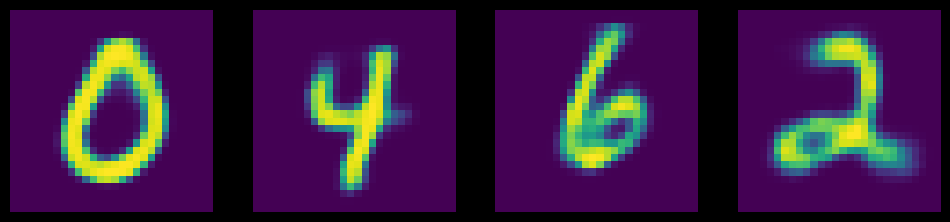

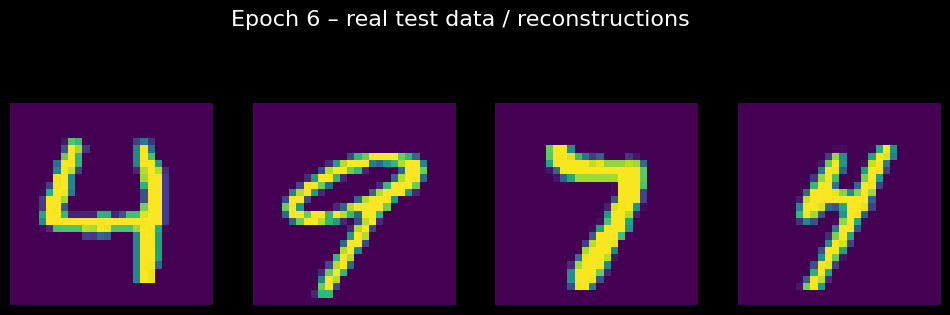

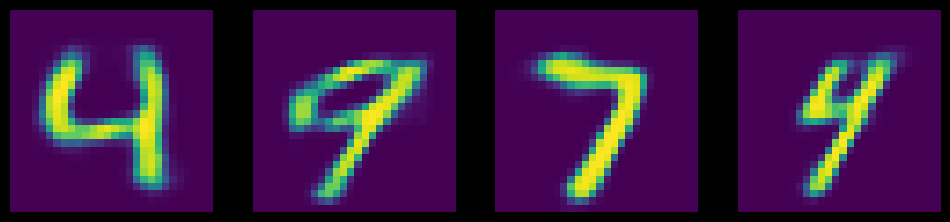

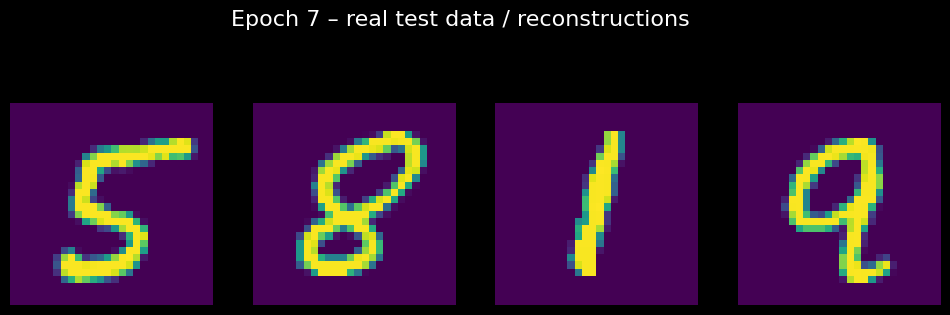

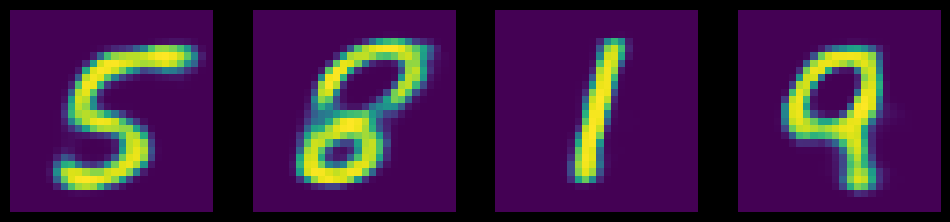

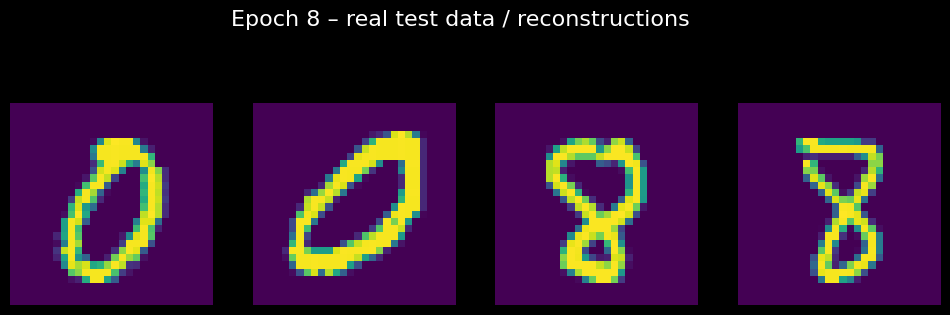

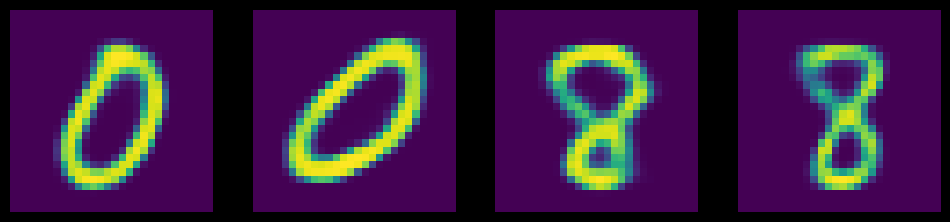

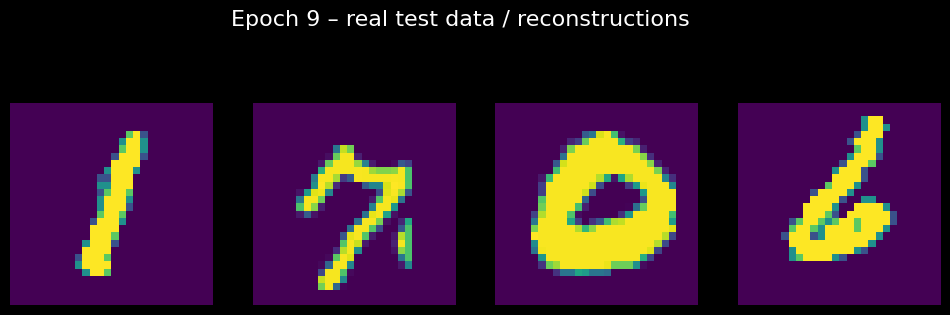

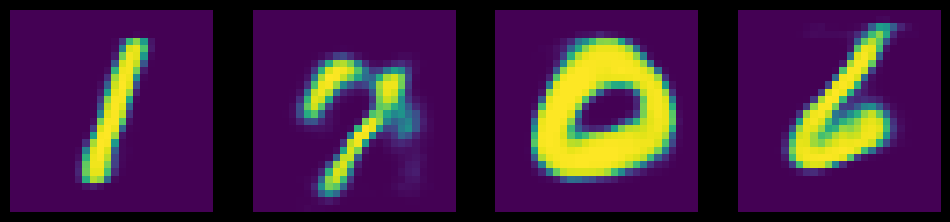

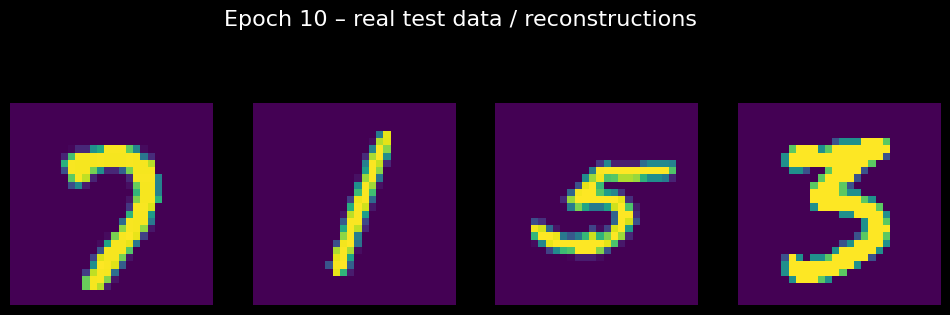

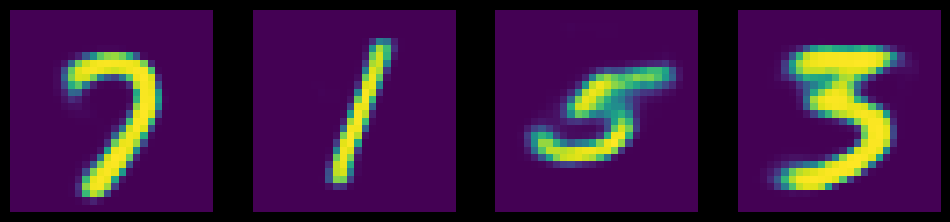

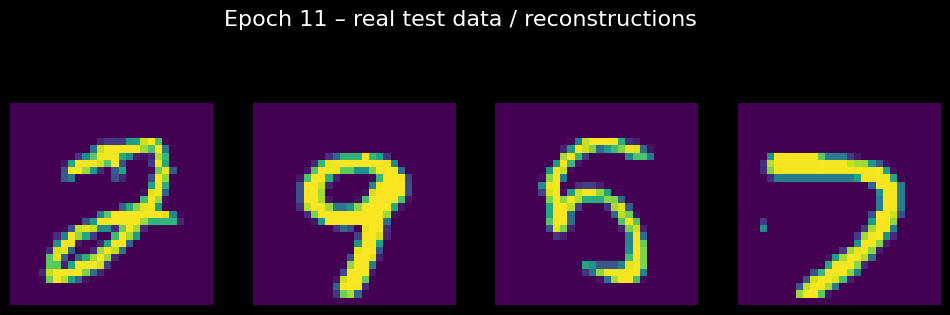

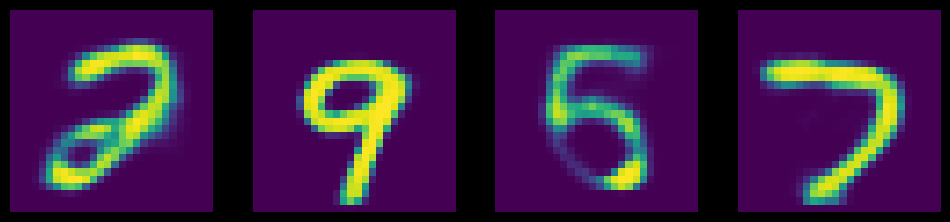

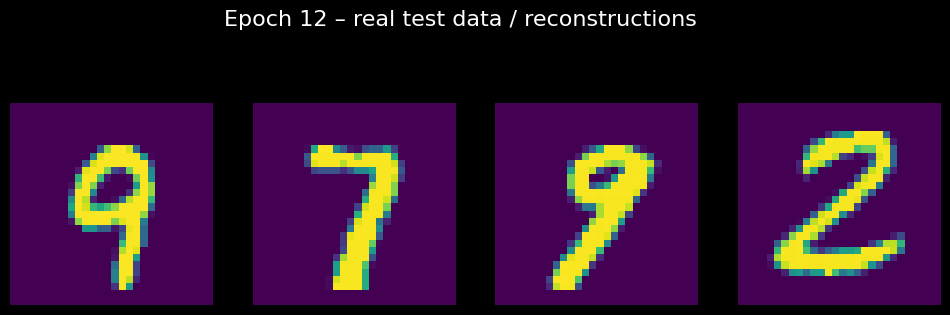

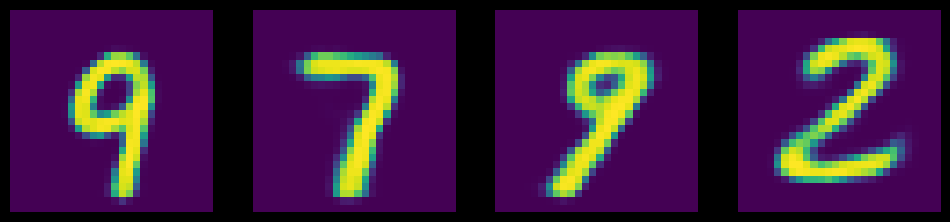

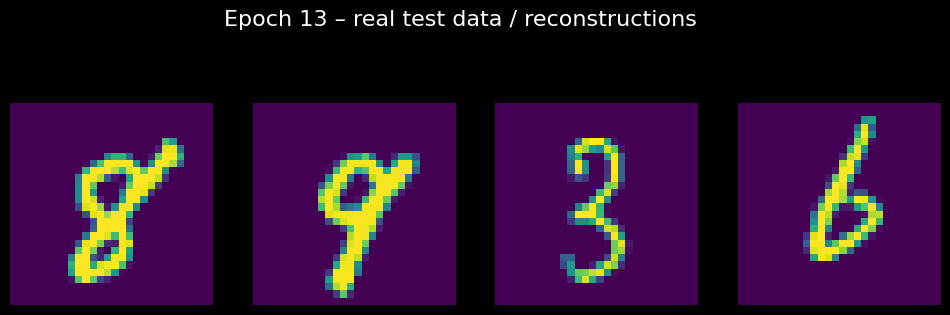

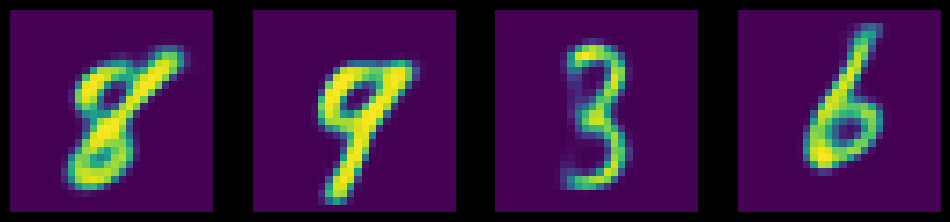

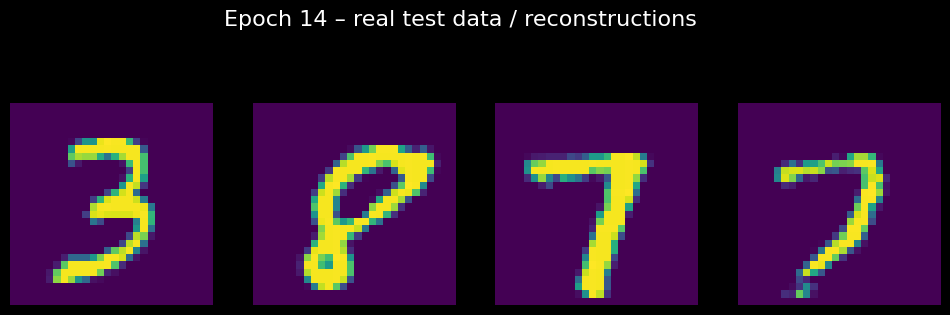

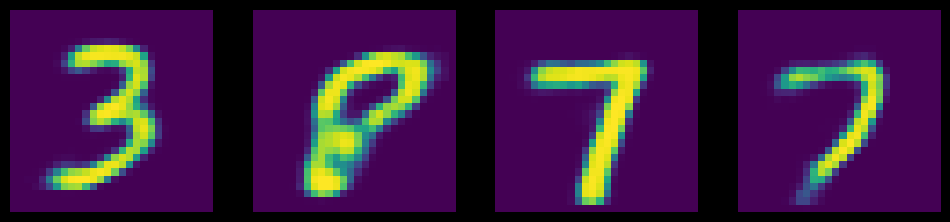

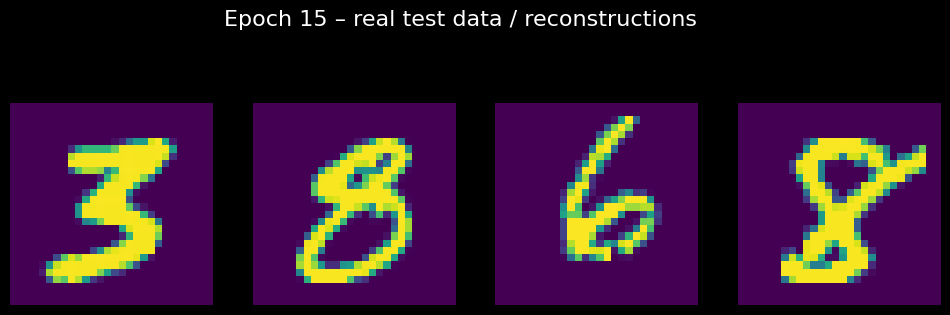

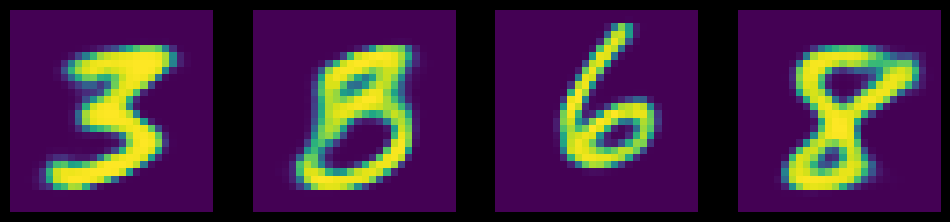

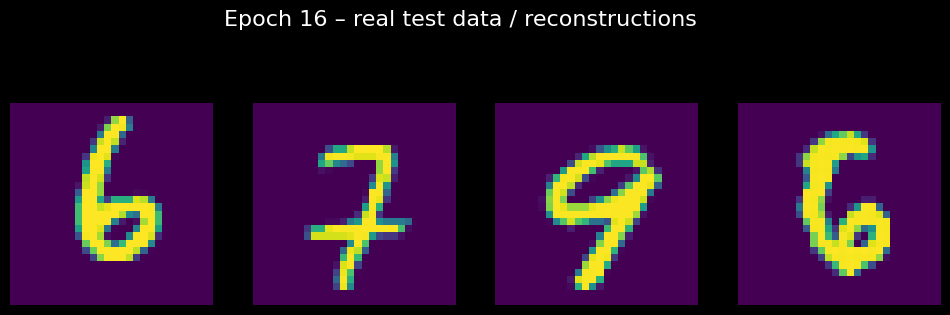

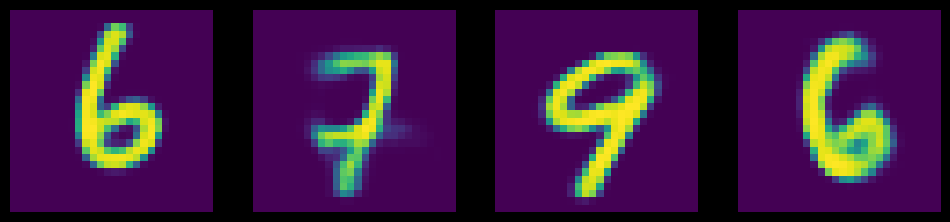

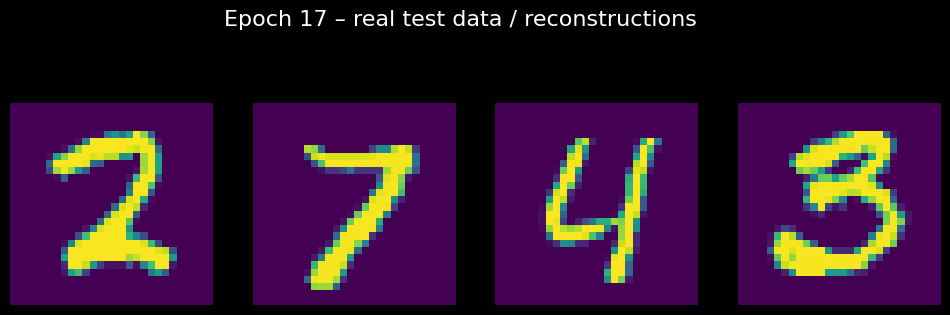

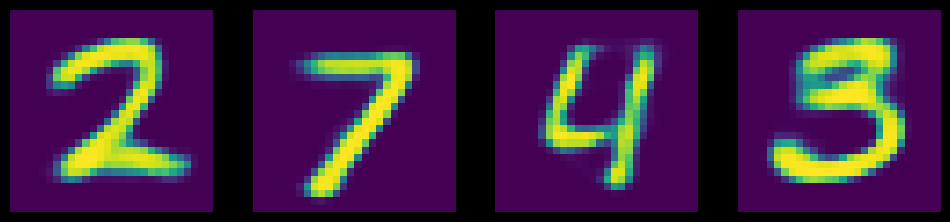

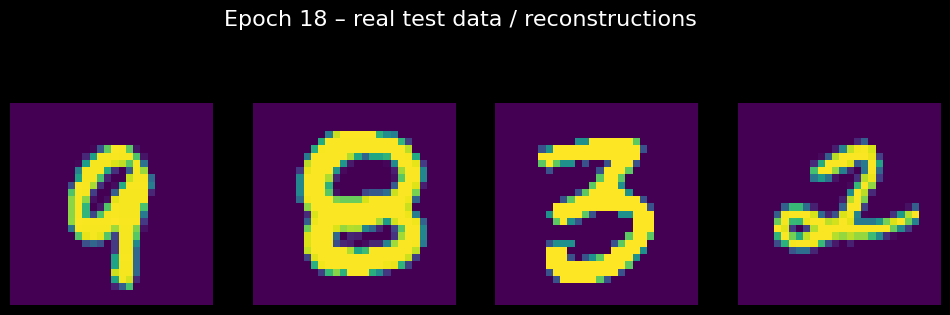

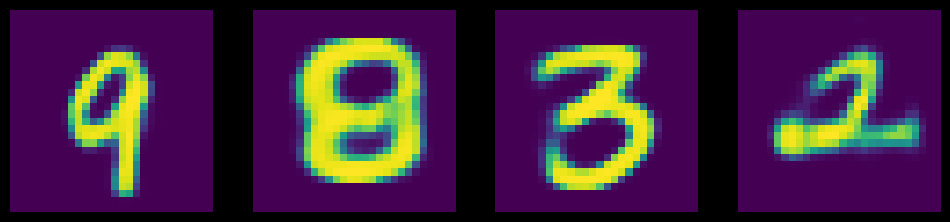

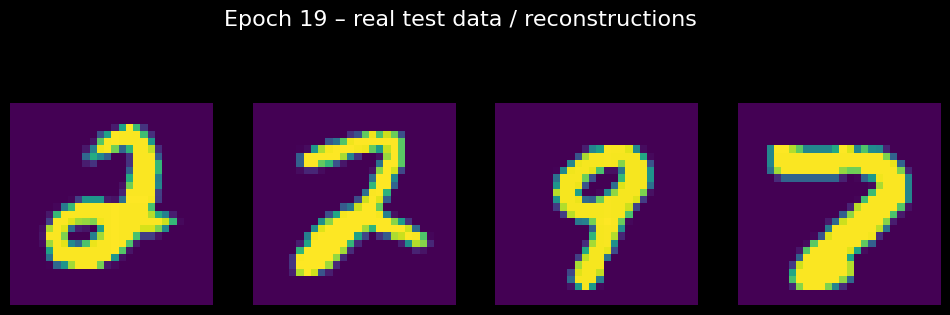

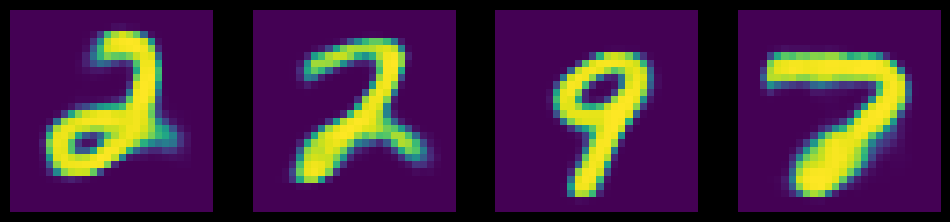

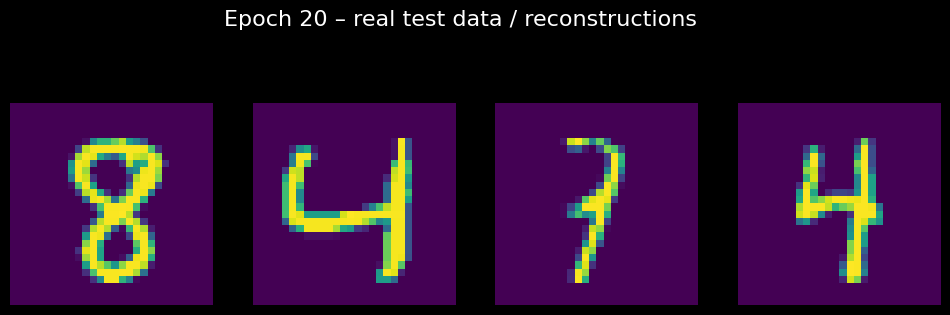

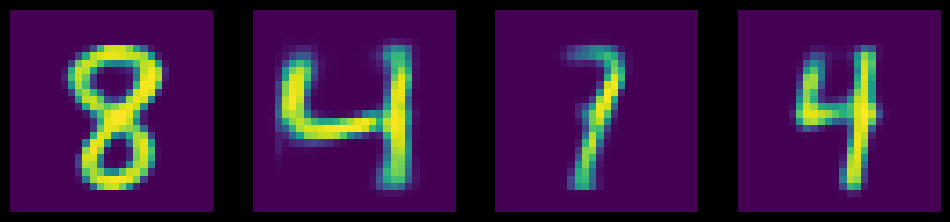

In [ ]:
epochs = 20
codes = dict(μ=list(), logσ2=list(), x=list())
for epoch in range(0, epochs + 1):
    # Training
    if epoch > 0:  # test untrained net first
        vae.train()
        t0 = time()
        train_loss = 0
        for y, _ in train_loader:
            y = y.to(device)
            # ===================forward=====================
            y_tilda, mu, logvar = vae(y)
            loss = loss_function(y_tilda, y, mu, logvar)
            train_loss += loss.item()
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # ===================log========================
        print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}, elapsed: {time() - t0:.1f}s')

    # Testing

    means, logvars, labels = list(), list(), list()
    with torch.no_grad():
        vae.eval()
        test_loss = 0
        for y, x in test_loader:
            y = y.to(device)
            # ===================forward=====================
            y_tilda, mu, logvar = vae(y)
            test_loss += loss_function(y_tilda, y, mu, logvar).item()
            # =====================log=======================
            means.append(mu.detach())
            logvars.append(logvar.detach())
            labels.append(x.detach())
    # ===================log========================
    codes['μ'].append(torch.cat(means))
    codes['logσ2'].append(torch.cat(logvars))
    codes['x'].append(torch.cat(labels))
    test_loss /= len(test_loader.dataset)
    print(f'====> Test set loss: {test_loss:.4f}')
    display_images(y, y_tilda, 1, f'Epoch {epoch}')

<a name="vae_generation"></a>
### Генерация из случайных векторов

Полученные изображения уже больше напоминают рукописные цифры, можно добиться более хорошего результата, но здесь нам достаточно обозначить разницу.

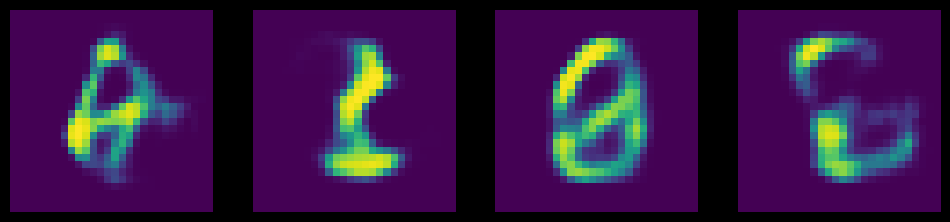

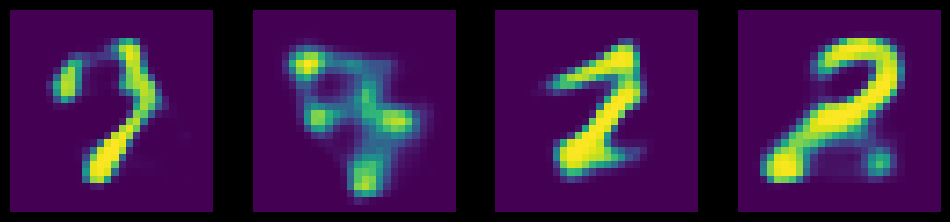

In [ ]:
display_images(None, vae.decoder(torch.randn(8, d).to(device)), 2)

<a name="vae_interp"></a>
### Интерполяция изображений

Посмотрим на первые 8 цифр последнего тестового батча

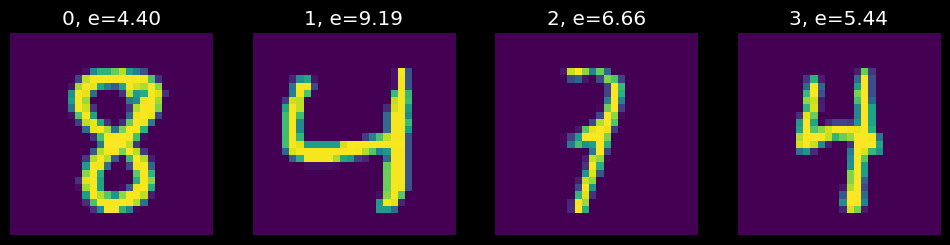

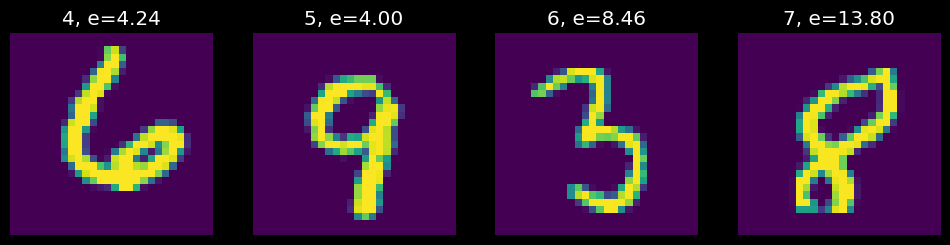

In [ ]:
with torch.no_grad():
    y_tilda = vae(y)[0].view(-1, 28, 28)
energy = y.squeeze().sub(y_tilda).pow(2).sum(dim=(1,2))
display_images(None, y, 2, count=True, energy=energy)

Выберем начальную и конечную точку для интерполяции (индексы 0 и 6) и посмотрим на:
* исходные и восстановленные изображения
* восстановленные и разницу с исходными

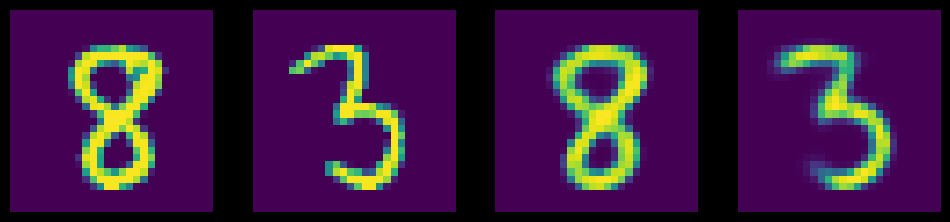

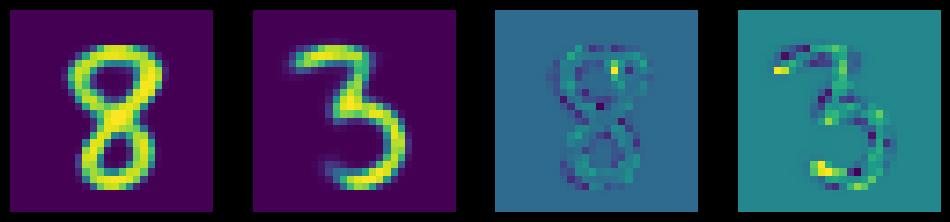

In [ ]:
A, B = 0, 6
sample = vae.decoder(torch.stack((mu[A].data, mu[B].data), 0))
display_images(None, torch.stack(((
    y[A].data.view(-1),
    y[B].data.view(-1),
    sample.data[0],
    sample.data[1],
    sample.data[0],
    sample.data[1],
    y[A].data.view(-1) - sample.data[0],
    y[B].data.view(-1) - sample.data[1]
)), 0), 2)

Выполним интерполяцию между A и B за N шагов сначала в исходном пространстве

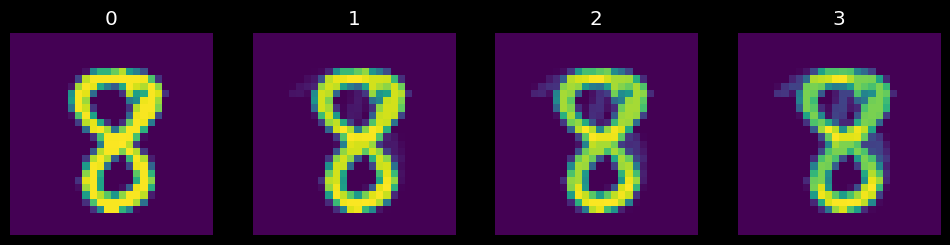

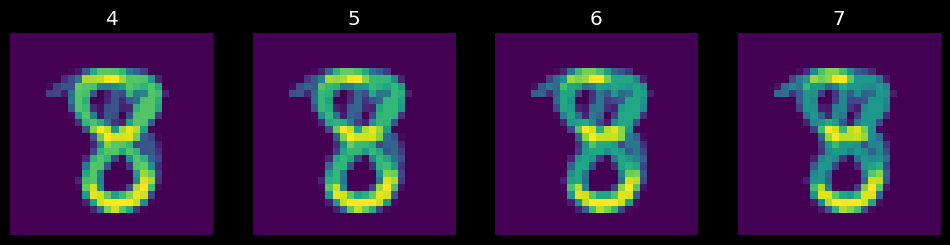

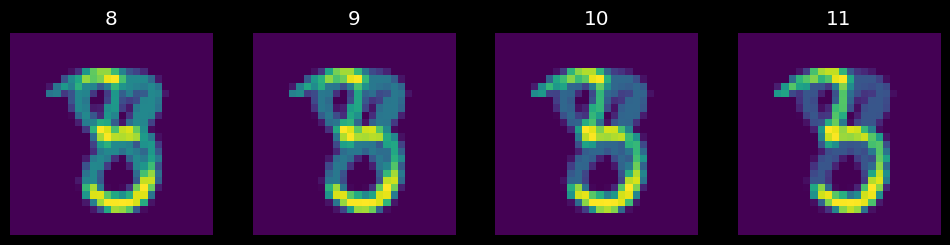

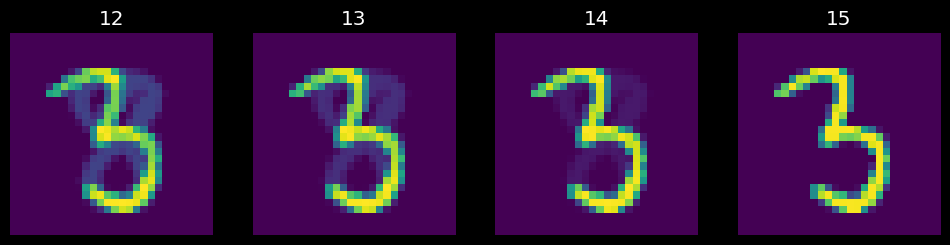

In [ ]:
N = 16
# code = torch.Tensor(N, 20).to(device)
samples = torch.Tensor(N, 28, 28).to(device)
for i in range(N):
    # code[i] = i / (N - 1) * mu[B].data + (1 - i / (N - 1) ) * mu[A].data
    samples[i] = i / (N - 1) * y[B].data + (1 - i / (N - 1) ) * y[A].data
# samples = vae.decoder(code)
display_images(None, samples, N // 4, count=True)

Затем в латентном пространстве

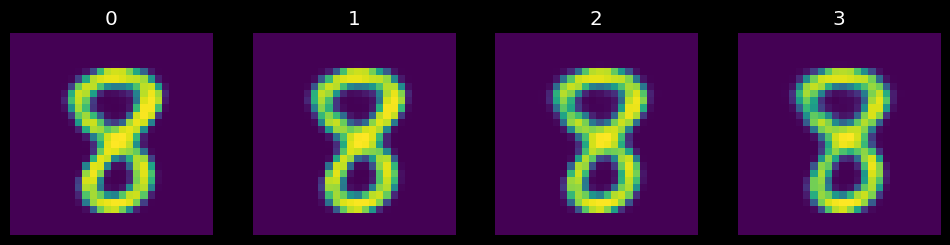

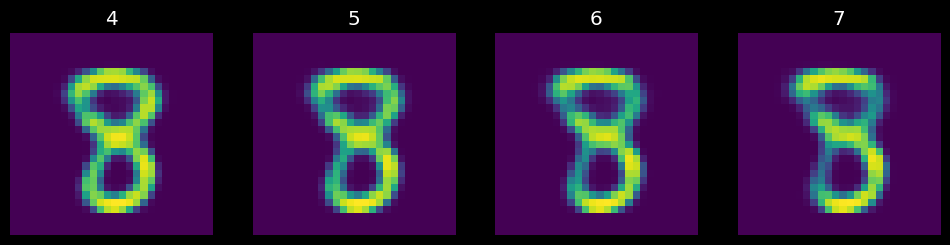

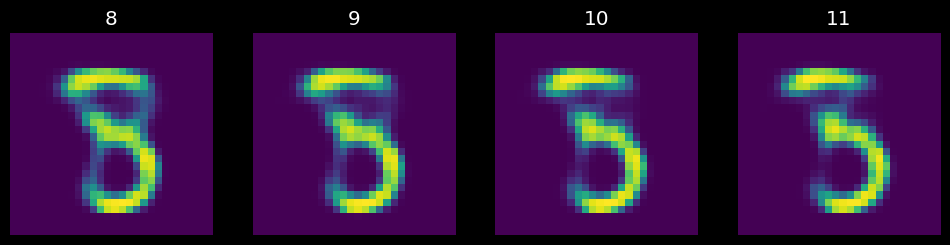

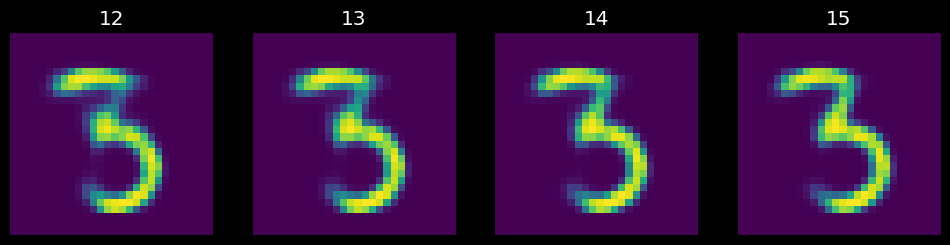

In [ ]:
# Perform an interpolation between input A and B, in N steps

N = 16
code = torch.Tensor(N, 20).to(device)
# samples = torch.Tensor(N, 28, 28).to(device)
for i in range(N):
    code[i] = i / (N - 1) * mu[B].data + (1 - i / (N - 1) ) * mu[A].data
    # samples[i] = i / (N - 1) * y[B].data + (1 - i / (N - 1) ) * y[A].data
samples = vae.decoder(code)
display_images(None, samples, N // 4, count=True)

Возьмём среднее изображений A и B (ну почти среднее - индекс 9 в массиве из 16) и подадим на вход модели как изображение, получим такую интересную конструкцию

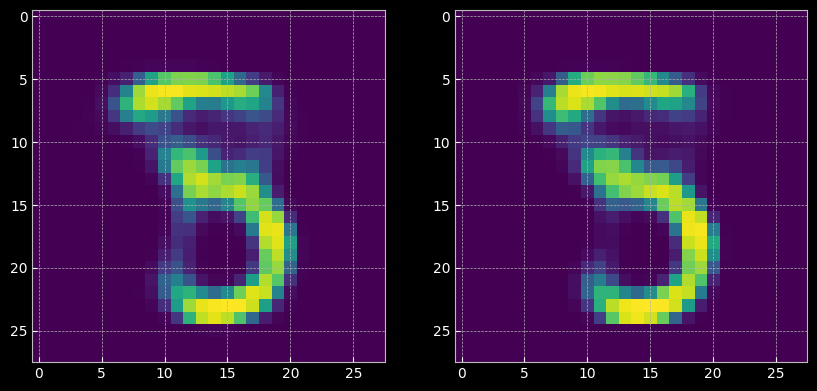

In [ ]:
y_dot = samples[9]
with torch.no_grad():
    y_tilda = vae(y_dot)[0]
plt.figure(figsize=(10,5))
plt.subplot(121), plt.imshow((y_dot.cpu().detach()).view(28, 28))
plt.subplot(122), plt.imshow((y_tilda.cpu()).view(28, 28));

**TODO:** Нужен ли график ниже и пересмотреть интерполяцию

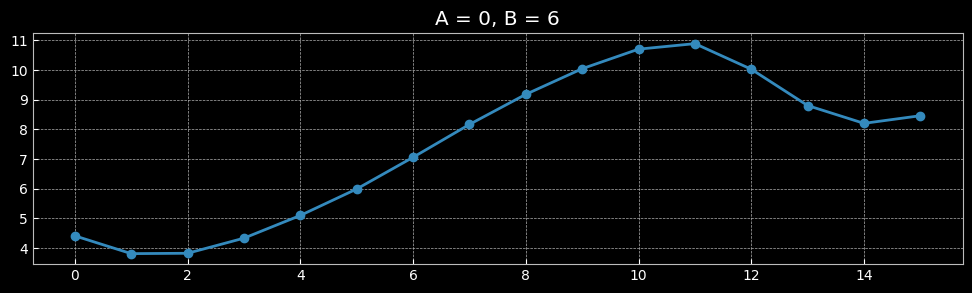

In [ ]:
N = 16
samples = torch.Tensor(N, 28, 28).to(device)
for i in range(N):
    samples[i] = i / (N - 1) * y[B].data + (1 - i / (N - 1) ) * y[A].data
with torch.no_grad():
    reconstructions = vae(samples)[0].view(-1, 28, 28)

plt.title(f'{A = }, {B = }')
plt.plot(samples.sub(reconstructions).pow(2).sum(dim=(1,2)).cpu(), '-o');

<a name="vae_tsne"></a>
### Визуализация эмбеддингов VAE

Для отладки математики deep learning часто используется визуализация - можно взять и глазами посмотреть на то, насколько результаты соответствуют ожиданиям.

Цветами закодированы цифры и мы видим, что с каждой эпохой с одной стороны происходит более чёткое разделение между кластерами цифр, а с другой стороны их уплотнение.

In [ ]:
import numpy as np
from sklearn.manifold import TSNE

In [ ]:
X, Y, E = list(), list(), list()  # input, classes, embeddings
N = 1000  # samples per epoch
epochs = (0, 5, 10)
for epoch in epochs:
    Y.append(codes['μ'][epoch][:N])
    E.append(TSNE(n_components=2).fit_transform(Y[-1].detach().cpu()))
    X.append(codes['x'][epoch][:N])

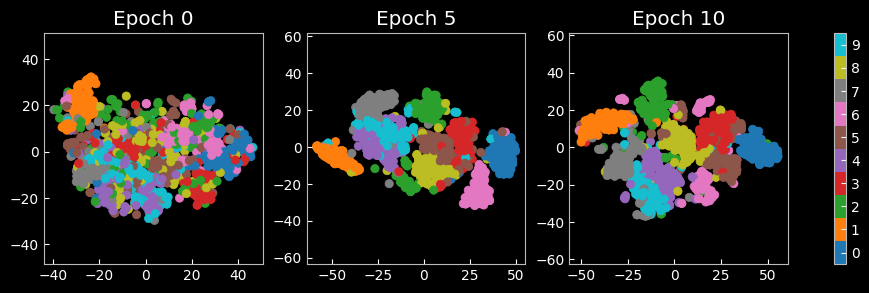

In [ ]:
f, a = plt.subplots(ncols=3)
for i, e in enumerate(epochs):
    s = a[i].scatter(E[i][:,0], E[i][:,1], c=X[i], cmap='tab10')
    a[i].grid(False)
    a[i].set_title(f'Epoch {e}')
    a[i].axis('equal')
f.colorbar(s, ax=a[:], ticks=np.arange(10), boundaries=np.arange(11) - .5)

## Упражнения

Попробуйте:

* использовать другой датасет, например FashionMNIST
* заменить loss в AE и DAE
  * TODO: предоставить варианты, которые можно попробовать
* поменять размерность латентного пространства для AE и DAE

P.S.

* Just for fun [Альтернативное объяснение GAN от Альфредо](https://youtu.be/bZF4N8HR1cc?list=PLLHTzKZzVU9e6xUfG10TkTWApKSZCzuBI&t=3306)
* [Disentangled AutoEncoder](https://youtu.be/9zKuYvjFFS8?t=546), который стремится сделать так, чтобы отдельные нейроны в латентном распределении были нескореллированными, чтобы каждый выучивал что-то своё про входные данные